# Раздел "Доходы"

Гипотезы: 
1. Нужно обязательно двухшаговое бюджетирование
2. Неверно заданы ограничения
3. Неверно исключено уравнение
4. Проблемы при получении агрегированных цен

Дополнительно:
1. Надо как-то учесть размер ДХ
2. Нужно как-то учесть тот факт, что мы смотрим на расходы на продукты питания, а не на доходы ДХ в целом

In [1]:
import RLMS_HSE.reading as readrlms
from importlib import reload  # Python 3.4+
readrlms = reload(readrlms)

In [2]:
import RLMS_HSE.AIDS as aids
from importlib import reload  # Python 3.4+
aids = reload(aids)

In [3]:
import pandas as pd

In [4]:
import os

In [5]:
os.path

<module 'ntpath' from 'C:\\Users\\79618\\anaconda3\\envs\\my_env\\lib\\ntpath.py'>

In [6]:
readrlms.FAST_variable_hh()

Волны 1993 года не существует.
Загружен 1994
Загружен 1995
Загружен 1996
Волны 1997 года не существует.
Загружен 1998
Волны 1999 года не существует.
Загружен 2000
Загружен 2001
Загружен 2002
Загружен 2003
Загружен 2004
Загружен 2005
Загружен 2006
Загружен 2007
Загружен 2008
Загружен 2009
Загружен 2010
Загружен 2011
Загружен 2012
Загружен 2013
Загружен 2014
Загружен 2015
Загружен 2016
Загружен 2017
Загружен 2018
Загружен 2019
Загружен 2020
Загружен 2021


In [7]:
RENAMED_HH_DFS={year:readrlms.columns_renamer(readrlms.FAST_HH_DFS[year]) for year in readrlms.FAST_HH_DFS.keys()}

## Проблема дохода

In [ ]:
income_food_cost={}
for key in RENAMED_HH_DFS.keys():
    income_food_cost[key]=readrlms.full_preprocessing(RENAMED_HH_DFS[key],
                                                      ['f14']).fillna(0).join(pd.DataFrame(aids.food_df(readrlms.FAST_HH_DFS[key],
                                                                                              'cost').sum(axis=1)/7*30,
                                                                                 columns=['food_cost']),how='inner')

In [ ]:
income_food_cost={}
for key in RENAMED_HH_DFS.keys():
    income_food_cost[key]=readrlms.full_preprocessing(RENAMED_HH_DFS[key],
                                                      ['f14']*7/30).fillna(0).join(pd.DataFrame(aids.food_df(readrlms.FAST_HH_DFS[key],
                                                                                              'cost').sum(axis=1),
                                                                                 columns=['food_cost']),how='inner')

In [ ]:
income_food_cost[2021]

In [ ]:
import numpy as np

In [ ]:
income_food_cost[2021].f14

In [ ]:
income_food_cost[2019].describe()

In [ ]:
delta_inc_food={}
for year in income_food_cost.keys():
    delta_inc_food[year]=(income_food_cost[year].f14-income_food_cost[year].food_cost)

In [ ]:
food_insecure={}
for year in delta_inc_food.keys():
    food_insecure[year]=(delta_inc_food[year]<0).value_counts()

In [ ]:
share_food_insecure={}
for year in food_insecure.keys():
    share_food_insecure[year]=food_insecure[year][True]/(food_insecure[year][True]+food_insecure[year][False])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

data=pd.Series(share_food_insecure)*100
ax = data.plot(kind='bar')
ax.grid()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Год')
ax.set_ylabel('Процент домохозяйств в выборке, затраты на\n продукты питания которых превышают их доход')

In [ ]:
food_neg_resids={}
for year in delta_inc_food.keys():
    food_neg_resids[year]=(delta_inc_food[year].loc[delta_inc_food[year]<0])

In [ ]:
import seaborn as sns
sns.scatterplot(data=pd.DataFrame(food_neg_resids).loc[:,2000:])

In [ ]:
pd.DataFrame(food_neg_resids)

Таким образом в выборке имеется сущесвтенная часть домохозяйств, чьи расходы на продукты питания превышают их доходы. 

Однако, у данного вывода есть ряд проблем. Как возможно, чтобы расходы превышали доходы в принципе? 
1. Доходы задекларированы некорректно. Респондент оценил неверно свои доходы или расходы на продукты питания.
2. Расходы на текущее потребление финансировались не из доходов, а из сбережений/займов. В таком случае над считать финансовые ресурсы потребителя. И исходя из них вычислять долю ДХ, чьи доходы превышают расходы. 
3. Расходы на питание даны за 7 дней, а доход дан за 30 дней. Отрицательный остаток??????? (не вариант скорее всего)
4. Особенно выдающиеся доли отрицательных остатков относятся к годам кризиса 90-ых, когда:
    * высокая и гиперинфляция могла мешать верным оценкам ДХ своих доходов и расходов
    * 

**Надо начинать с более очевидного!**

**Составим гипотезы для проверки.**
1. **САМАЯ ОЧЕВИДНАЯ:** респонденты тратят на продукты питания свои финансовые ресурсы, т.е. займы и сбережения. 

2. Некорректность декларации доходов и расходов на питание может быть выявлена следующим образом:
**Интервьюер может заподозрить ошибку или фальсфикацию данных респондентом. Тогда есть несколько вариантов действия:**

(1) Построить регрессию на полной выборке с y=доходом и x=объясняющими переменными и индикаторами фальсфикации. Такая модель позволит выявить есть ли зависимость на полной выборке между индикаторами неверности данных и доходом. 

(2) Аналогично, но только для тех, кто у кого доход был ниже расходов на продукты. Может выявить фальсификацию исходя из подозрение интервьюера. 

(3) Построить логистическую регрессию, где y=факт отрицательного остатка, а X=переменные индикаторы фальсификации. Такая модель позволит протестировать являтся ли чувства интервьюера предиктором отрицательности остатка. Это может сулжить косвенным свидетельством в пользу фальсфикации. 

**Выявление проблем**
1. Сравнение прямо задекларированного дохода и расходов на продукты питания
2. Сравнение расхоов по направлением и прямо задекларированного дохода ДХ

## Подсчет финансовых ресурсов ДХ

In [ ]:
import RLMS_HSE.AIDS as aids
from importlib import reload  # Python 3.4+
aids = reload(aids)

Все финансовые ресурсы:
1. **INCOME**: ``F14`` Каким был денежный доход всей Вашей семьи в течение
последних 30 дней? Включите сюда все денежные поступления
всех членов семьи, в том числе и в валюте, но валюту
переведите в рубли
2. **SAVINGS**: ``F13.2B`` На какую сумму в рублях Ваша семья тратила сбережения,
продавала драгоценности, накопленную валюту в течение
последних 30 дней?
3. **CREDIT**: ``F13.11B`` Сколько в рублях Ваша семья взяла в кредит в течение
последних 30 дней?

In [ ]:
finres_food_cost={}
for key in RENAMED_HH_DFS.keys():
    finres_food_cost[key]=readrlms.full_preprocessing(RENAMED_HH_DFS[key],
                                                      list(set(RENAMED_HH_DFS[key].columns)&set(['f13.1b','f13.2b', 'f13.11b','f14']))).fillna(0).join(pd.DataFrame(aids.food_df(readrlms.FAST_HH_DFS[key],
                                                                                              'cost').sum(axis=1)/7*30,
                                                                                 columns=['food_cost']),how='inner')

In [ ]:
finres_food_cost[2021]

In [ ]:
income_food_cost[2021]

In [ ]:
finres_food_cost[year].fillna(0).iloc[:,:3]

In [ ]:
finres_food_cost[2021].fillna(0).describe()

In [ ]:
income_food_cost[2021].fillna(0).describe()

In [ ]:
finres_food_cost[2021].describe()

In [ ]:
finres_food={}
for year in finres_food_cost.keys():
    finres_food[year]=(finres_food_cost[year].fillna(0).iloc[:,:3].sum(axis=1))

In [ ]:
delta_finres_food={}
for year in finres_food_cost.keys():
    delta_finres_food[year]=(finres_food_cost[year].fillna(0).iloc[:,:3].sum(axis=1)-finres_food_cost[year].food_cost)

In [ ]:
delta_finres_food[2000]

In [ ]:
delta_finres_food[2000].loc[delta_finres_food[2000]<0].describe()

In [ ]:
delta_inc_food[2000].loc[delta_inc_food[2000]<0].describe()

In [ ]:
finres_food_cost[2021].food_cost!=0

In [ ]:
strong_food_insecure={}
for year in delta_finres_food.keys():
    strong_food_insecure[year]=(delta_finres_food[year]<0).value_counts()

In [ ]:
strong_food_insecure[2021]

In [ ]:
food_insecure[2021]

In [ ]:
strong_share_food_insecure={}
for year in strong_food_insecure.keys():
    strong_share_food_insecure[year]=strong_food_insecure[year][True]/(strong_food_insecure[year][True]+strong_food_insecure[year][False])

In [ ]:
strong_share_food_insecure[2020]*100

In [ ]:
share_food_insecure[2020]*100

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

data=pd.Series(strong_share_food_insecure)*100
ax = data.plot(kind='bar')
ax.grid()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Год')
ax.set_ylabel('Процент домохозяйств в выборке, затраты на\n продукты питания которых превышают их доход')

In [ ]:
s1, s2=pd.Series(strong_share_food_insecure)*100, pd.Series(share_food_insecure)*100
df_w_s=pd.concat([s1, s2], axis=1)
df_w_s=df_w_s.rename(columns={0:'strong',1:'weak'})
df_w_s

In [ ]:
data=df_w_s
ax = data.plot(kind='bar')
ax.grid()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xlabel('Год', fontweight='bold')
ax.set_ylabel('Доля домохозяйств в выборке, затраты на\n продукты питания которых превышают\n их располагаемые ресурсы',fontweight='bold')
ax.legend(['Финансовые ресурсы', 'Доходы'], title='Располагаемые ресурсы:')

In [ ]:
((df_w_s.strong-df_w_s.weak)<0).astype(int).plot()

In [ ]:
Доля сильно

Доля слабо

**Интерпретация**
1. Использование показателя финансовых ресурсов, вместо оценки суммарного дохода ДХ не решает проблемы того, что ДХ недекларируют свой полный доход хотя бы равный раходам на продукты питания. Более того, проблема становится более выразительной, т.к., судя по всему, из выборки исключаются 
2. 

In [ ]:
sns.barplot

In [ ]:
finres_food_cost[2000].fillna(0).iloc[:,:3]

In [ ]:
((finres_food_cost[2000].fillna(0).iloc[:,:3].sum(axis=1)-finres_food_cost[2000].food_cost)<0).value_counts()

**Отбор релевантных доходам ДХ фичей**

* ``F14`` Каким был денежный доход всей Вашей семьи в течение
последних 30 дней? Включите сюда все денежные поступления
всех членов семьи, в том числе и в валюте, но валюту
переведите в рубли

**Кредитование**
* ``F13.1B`` Сколько в рублях Ваша семья взяла в кредит, в долг в течение последних 30 дней?
* ``F13.2B`` На какую сумму в рублях Ваша семья тратила сбережения, продавала драгоценности, накопленную валюту в течение последних 30 дней?
* ``F13.11B`` Сколько в рублях Ваша семья взяла в кредит в течение последних 30 дней?

In [ ]:
readrlms.wave_scanner(['f13.1b','f13.2b', 'f13.11b','f14','f14.9','f14.3', 'f14.0'],where='hh')

* F4 Сколько денег доплатили Вашей семье на топливо в течение
последних 30 дней?
* F7 Сколько всего денег получили члены Вашей семьи в течение
последних 30 дней в качестве пособий на детей? 
* F7.1 Сколько всего денег получили члены Вашей семьи в течение
последних 30 дней в качестве пособий на детей в возрасте
до полутора лет?
* F7.2 Сколько всего денег получили члены Вашей семьи в течение
последних 30 дней в качестве пособий на детей в возрасте
от 1,5 до 16 лет или, если они учатся в
общеобразовательном учреждении, до 18лет?
* F9.1B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от родителей Ваших или
супруга(и)?
* F9.2B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от детей Ваших или
супруга(и)?
* F9.3B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от бабушек и дедушек Ваших
или супруга(и)?
* F9.4B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от внуков Ваших или
супруга(и)?
* F9.5B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от других родственников Ваших
или супруга(и)?
* F9.6B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от друзей?
* F9.7B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней с прежнего места работы коголибо из членов Вашей семьи?
* F9.8B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от религиозных организаций:
церкви, мечети, синагоги?
* F9.9B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от зарубежных и международных
организаций?
* F9.91B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от социальных органов
государства, не включая пенсии и пособия на детей?
* F9.10B Оцените в рублях сколько получила Ваша семья безвозмездно
в течение последних 30 дней от других организаций и
частных лиц?
* F11 Сколько получила Ваша семья за вычетом налогов и других
отчислений в течение последних 30 дней? Если оплата
производилась в форме товаров или услуг, оцените, сколько
это будет в рублях?
* F12.1AB Сколько в рублях ежемесячных денежных выплат взамен
натуральных льгот, не считая льгот по оплате ЖКХ,
получила Ваша семья в течение последних 30 дней?
* F12.1B Сколько в рублях пенсии, включая доплаты от Пенсионного
фонда РФ, от государства, получила Ваша семья в течение
последних 30 дней?
* F1210CB Сколько в рублях льгот по оплате квартиры и коммунальных
услуг получила Ваша семья в течение последних 30 дней?
* F1210DB Сколько составили в рублях льготы, которые
предоставляются в виде уменьшения суммы оплаты квартиры и
коммунальных услуг, в течение последних 30 дней?
* F12.2B Сколько в рублях стипендии получила Ваша семья в течение
последних 30 дней?
* F12.3B Сколько в рублях пособий по безработице получила Ваша
семья в течение последних 30 дней?
* F12.4B Сколько в рублях дохода от продажи личного имущества
получила Ваша семья в течение последних 30 дней?
* F12.5B Сколько в рублях дохода от сдачи в аренду имущества
получила Ваша семья в течение последних 30 дней?
* F12.6B Сколько в рублях дохода от вложения капитала получила
Ваша семья в течение последних 30 дней?
* F12.6AB Сколько в рублях процентов по вкладам получила Ваша семья
в течение последних 30 дней?
* F12.6BB Сколько в рублях дохода по акциям, облигациям, ценным
бумагам и другим видам вложения капитала получила Ваша
семья в течение последних 30 дней?
* F12.7B Сколько в рублях выплат по страховкам получила Ваша семья
в течение последних 30 дней?
* F12.8B Сколько в рублях алиментов получила Ваша семья в течение
последних 30 дней?
* F12.9B Сколько в рублях денег от возврата Вам долгов получила
Ваша семья в течение последних 30 дней?
* F12.10B Сколько составили в рублях субсидии или льготы по оплате
квартиры, которые получила Ваша семья в течение последних
30 дней?
* F1210AB Сколько составили в рублях субсидии по оплате квартиры,
которые получила Ваша семья в течение последних 30 дней?
* F1210BB Сколько в рублях льгот по оплате квартиры и коммунальных
услуг, не считая субсидии, получила Ваша семья в течение
последних 30 дней?
* F13.1B Сколько в рублях Ваша семья взяла в кредит, в долг в
течение последних 30 дней?
* F13.2B На какую сумму в рублях Ваша семья тратила сбережения,
продавала драгоценности, накопленную валюту в течение
последних 30 дней?
* F13.3B Сколько в рублях Ваша семья получила от продажи акций или
других ценных бумаг в течение последних 30 дней?



* F11 Сколько получила Ваша семья за вычетом налогов и других
отчислений в течение последних 30 дней? Если оплата
производилась в форме товаров или услуг, оцените, сколько
это будет в рублях?


**Скорее всего понадобиться для учета того, является ли кредит ипотечным, а не потребительским**

* F14.71 На какие цели брали кредит? (первый ответ)
* F14.72 На какие цели брали кредит? (второй ответ)
* F14.73 На какие цели брали кредит? (третий ответ)
* F14.74 На какие цели брали кредит? (четвертый ответ)

**Подсчет чистых обязательства ДХ**:

* F13.11B Сколько в рублях Ваша семья взяла в кредит в течение
последних 30 дней?
* F14.9 Сколько всего денег по кредитам должна Ваша семья на
сегодняшний день (в рублях)?
* F13.12B Сколько в рублях Ваша семья взяла в долг у частных лиц в
течение последних 30 дней?
* F14.11 Сколько всего денег частным лицам должна Ваша семья на
сегодняшний день (в рублях)?
* F14.13 Сколько всего денег должны Вашей семье на сегодняшний
день (в рублях)?
* F14.3 Сколько всего денег должна Ваша семья? Если долги
исчисляются в долларах, то переведите эту сумму в рубли


30 дней
Полные чистые обязательства = сколько всего кредитов: F14.9 + F14.11 - F14.13
F14.3 ????????????????????????
Чистый прирост обязательств (30 дней) = f13.11b + F13.12B + 

**Сбережения**

F14.0 Сколько Вашей семье удалось накопить, то есть какие
сбережения есть у Вашей семьи на сегодняшний день - дома
или на банковских вкладах, в рублях или в валюте, или в
ценных бумагах? Оцените, сколько это будет в рублях.


In [ ]:
F15 Как Вы считаете, Вы все знаете о доходах членов Вашей
семьи за последние 30 дней?


## Доли дохода

In [ ]:
import RLMS_HSE.reading as readrlms
from importlib import reload  # Python 3.4+
readrlms = reload(readrlms)

In [ ]:
import RLMS_HSE.AIDS as aids
from importlib import reload  # Python 3.4+
aids = reload(aids)

In [ ]:
food_shares_inc={}
for year in income_food_cost.keys():
    d=income_food_cost[year].loc[delta_inc_food[year]>0]
    food_shares_inc[year]=d.food_cost/d.f14
    food_shares_inc[year]=food_shares_inc[year].loc[food_shares_inc[year]!=0]

In [ ]:
food_shares_inc[2021]

In [ ]:
non_food_shares_inc={year: 1-food_shares_inc[year] for year in food_shares_inc.keys()}

In [ ]:
def AIDS_first_stage(year):
    df=pd.concat([food_shares_inc[year],non_food_shares_inc[year]],axis=1)
    df.columns=['food','nonfood']
    return df

In [ ]:
AIDS_first_stage(2018).mean()

In [ ]:
pd.concat([food_shares_inc[2021],non_food_shares_inc[2021]],axis=1)

## Репликация таблицы Рощиной с номинальными и дефлированными суммарными доходами ДХ, 1994-2012

In [12]:
only_income={}
for key in RENAMED_HH_DFS.keys():
    only_income[key]=readrlms.full_preprocessing(RENAMED_HH_DFS[key],
                                                      list(set(RENAMED_HH_DFS[key].columns)&set(['f14'])))

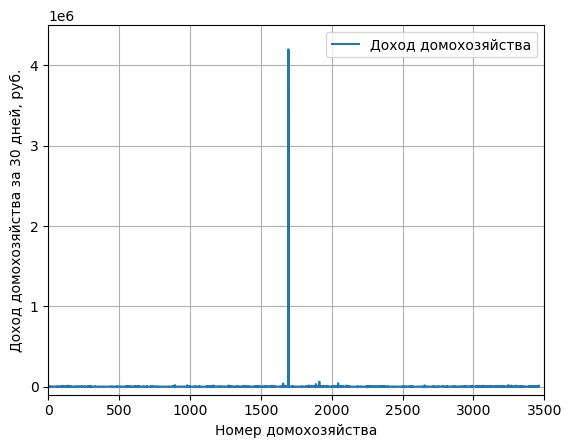

In [27]:
import matplotlib.pyplot as plt
only_income[1998].plot()
plt.grid()
plt.xlim(0,3500)
plt.ylim(-100000, 4.5*1e6)
plt.xlabel('Номер домохозяйства')
plt.ylabel('Доход домохозяйства за 30 дней, руб.')
plt.legend(['Доход домохозяйства'])

In [29]:
# Исключаем выброс из 1998 года, который смещает оценку почти в 2 раза. 
only_income[1998]=only_income[1998].loc[only_income[1998].f14!=4198054.0]

Text(0, 0.5, 'Доход домохозяйства за 30 дней, руб.')

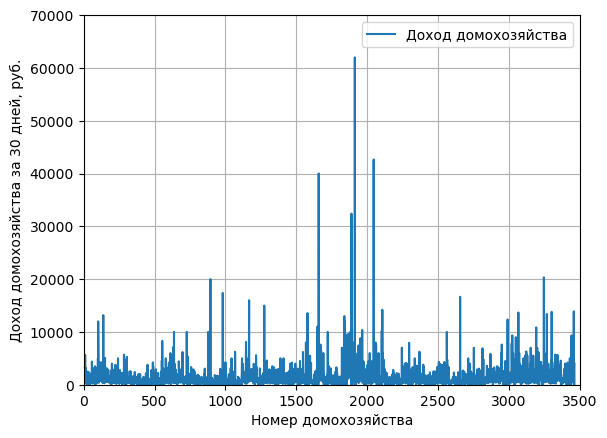

In [31]:
only_income[1998].plot()
plt.grid()
plt.xlim(0,3500)
plt.ylim(0, 70000)
plt.legend(['Доход домохозяйства'])
plt.xlabel('Номер домохозяйства')
plt.ylabel('Доход домохозяйства за 30 дней, руб.')

In [21]:
import pandas as pd
df = pd.read_excel(r'C:\Users\79618\Downloads\ipc_s_1992.xlsx')

In [22]:
cpi_df=pd.DataFrame(list(df.loc[3][1:]),index=list(df.loc[2][1:].apply(int)))

In [23]:
cpi_df

,0
1992,2608.84
1993,939.9
1994,315.14
1995,231.3
1996,121.81
1997,111.03
1998,184.43
1999,136.53
2000,120.18
2001,118.58


In [24]:
cpi_dict={year:float(cpi_df.loc[year].values[0])  for year in cpi_df.index}

In [25]:
def deflated_inc(from_year, to_year):
    df_copy=only_income[from_year].copy(deep=1)
    for year in range(from_year+1, to_year+1):
        df_copy=df_copy*(cpi_dict[year])/100
    if from_year<1998:
        return df_copy/1000
    else:
        return df_copy

<AxesSubplot:>

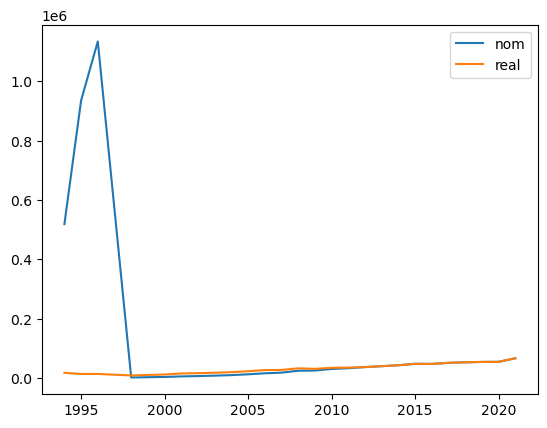

In [26]:
pd.DataFrame({year:{'nom':only_income[year].f14.mean(),'real':deflated_inc(year, 2012).f14.mean()} for year in only_income.keys()}).T.plot()

In [197]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [200]:
pd.DataFrame({year:{'nom':only_income[year].f14.mean(),'real':deflated_inc(year, x).f14.mean()} for year in only_income.keys()}).T.to_excel("output.xlsx")

In [201]:
pd.DataFrame({year:{'nom':only_income[year].f14.mean(),'real':deflated_inc(year, x).f14.mean()} for year in only_income.keys()}).T

,nom,real
1994,518343.71,30343.82
1995,935062.42,23665.59
1996,1134117.07,23564.14
1998,1444.99,14661.76
2000,3286.94,20326.04
2001,5042.88,26298.39
2002,6196.45,28084.65
2003,7627.98,30871.39
2004,9406.10,34071.11
2005,12140.65,39646.88


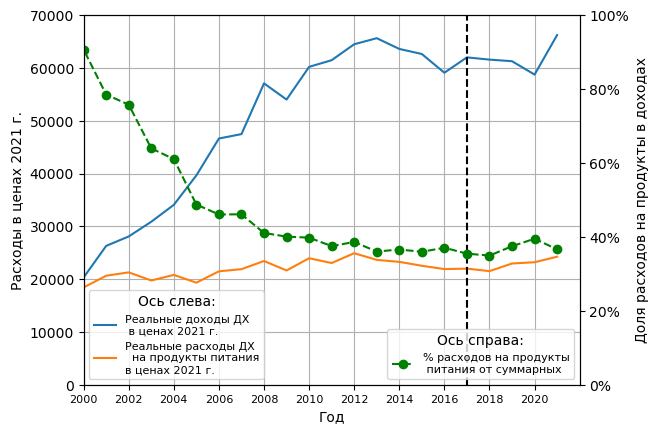

In [145]:
x=2021
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pd.DataFrame({year:{'nom':only_income[year].f14.mean(),'real':deflated_inc(year, x).f14.mean()} for year in only_income.keys()}).T.real, label='Реальные доходы ДХ\n в ценах 2021 г.')
ax.plot(pd.DataFrame({year:{'nom':f_cost[year].mean(),'real':deflated_food(year, x).mean()} for year in only_income.keys()}).T.real*30/7, label='Реальные расходы ДХ\n  на продукты питания\nв ценах 2021 г.')
plt.grid()
plt.xticks(list(range(2000,2022))[::2], fontsize=8)
plt.xlabel('Год')
plt.ylabel('Расходы в ценах 2021 г.')
plt.xlim(2000,2022)
plt.ylim(0,70000)
plt.vlines(2017,0,70000, linestyles='--', colors='black')
ax2 = ax.twinx()
ax2.plot((pd.DataFrame({year:{'nom':f_cost[year].mean(),'real':deflated_food(year, x).mean()*30/7} for year in only_income.keys()}).T.real/pd.DataFrame({year:{'nom':only_income[year].f14.mean(),'real':deflated_inc(year, x).f14.mean()} for year in only_income.keys()}).T.real*100), 'go--', label='% расходов на продукты\n питания от суммарных')
ax2.set_ylim(0, 100)
ax2.set_ylabel(r"Доля расходов на продукты в доходах")
ax2.legend(title='Ось справа:',loc='lower right',fontsize="8")
ax.legend(title='Ось слева:',loc='lower left',fontsize="8")

import matplotlib.ticker as mtick


fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax2.yaxis.set_major_formatter(yticks)

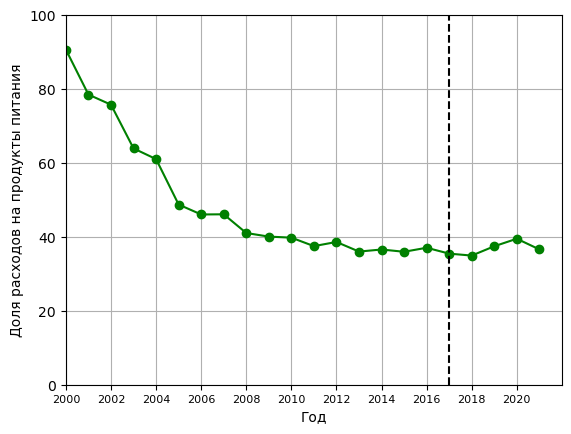

In [101]:
(pd.DataFrame({year:{'nom':f_cost[year].mean(),'real':deflated_food(year, x).mean()*30/7} for year in only_income.keys()}).T.real/pd.DataFrame({year:{'nom':only_income[year].f14.mean(),'real':deflated_inc(year, x).f14.mean()} for year in only_income.keys()}).T.real*100).plot(style='g-o')
plt.grid()
plt.xlabel('Год')
plt.ylabel('Доля расходов на продукты питания')
plt.xlim(2000,2022)
plt.xticks(list(range(2000,2022))[::2], fontsize=8)
plt.ylim(0,100)
plt.vlines(2017,0,100, linestyles='--', colors='black')

In [63]:
pd.DataFrame({year:{'nom':f_cost[year].mean(),'real':deflated_food(year, x).mean()} for year in only_income.keys()}).T

,nom,real
1994,152537.564800,8929.541735
1995,308276.114428,7802.191512
1996,320609.147870,6661.464173
1998,463.080421,4698.706305
2000,695.360425,4300.030743
2001,923.663661,4816.859763
2002,1095.465447,4965.059516
2003,1138.000556,4605.629566
2004,1339.813047,4853.118928
2005,1380.987752,4509.793928


In [ ]:
def deflated_inc(from_year, to_year):
    df_copy=only_income[from_year].copy(deep=1)
    for year in range(from_year+1, to_year+1):
        df_copy=df_copy*(cpi_dict[year])/100
    if from_year<1998:
        return df_copy/1000
    else:
        return df_copy

{1994:             f14
 0     1500000.0
 1     1329000.0
 2      140000.0
 3      156000.0
 4      670000.0
 ...         ...
 3970   137400.0
 3971   685000.0
 3972  1255000.0
 3973  1007000.0
 3974   160000.0
 
 [3861 rows x 1 columns],
 1995:             f14
 0     2696000.0
 1      880370.0
 2      665000.0
 3           0.0
 4      300000.0
 ...         ...
 3749  1447000.0
 3750   590000.0
 3751  2200000.0
 3752  2000000.0
 3754   575000.0
 
 [3624 rows x 1 columns],
 1996:             f14
 0     4020000.0
 1      964000.0
 2      680000.0
 3     1350000.0
 4      470000.0
 ...         ...
 3585   807000.0
 3586  2600000.0
 3588  2000000.0
 3589   374000.0
 3590  3500000.0
 
 [3440 rows x 1 columns],
 1998:          f14
 0     2800.0
 1     1700.0
 2      388.0
 3     1450.0
 4      628.0
 ...      ...
 3459  2800.0
 3460  2000.0
 3461     0.0
 3462  2100.0
 3463  4000.0
 
 [3357 rows x 1 columns],
 2000:           f14
 0      3084.0
 1      2780.0
 2       500.0
 3      3000.0
 4 

In [48]:
f_cost={year: aids.food_agregates(readrlms.FAST_HH_DFS[year], 'cost', including=['total']).Сумма for year in readrlms.FAST_HH_DFS.keys()}

In [49]:
f_cost

{1994: 0       122200.0
 1       376800.0
 5        92580.0
 7        93450.0
 14      203370.0
           ...   
 3957    143150.0
 3964    137900.0
 3965     68700.0
 3967     71670.0
 3973    266820.0
 Name: Сумма, Length: 500, dtype: float64,
 1995: 0       253700.0
 1       261300.0
 9       171100.0
 15      331000.0
 19      403800.0
           ...   
 3746    208700.0
 3747    384150.0
 3750    197200.0
 3751    469450.0
 3752    547200.0
 Name: Сумма, Length: 402, dtype: float64,
 1996: 0       352300.0
 1       228800.0
 4       285400.0
 8        88600.0
 14      112200.0
           ...   
 3562    508700.0
 3564    636700.0
 3572    377600.0
 3580    200500.0
 3584    246800.0
 Name: Сумма, Length: 399, dtype: float64,
 1998: 0       418.15
 9       399.80
 16      309.00
 53      539.70
 55      159.50
          ...  
 3447    390.40
 3448    334.20
 3459    368.80
 3460    411.10
 3463    737.90
 Name: Сумма, Length: 380, dtype: float64,
 2000: 0        435.00
 3       24

In [ ]:
pd.DataFrame({year:{'nom':only_income[year].f14.mean(),'real':deflated_inc(year, x).f14.mean()} for year in only_income.keys()}).T.real.plot()

In [ ]:
deflated_inc(year, x).f14.mean()

In [50]:
def deflated_food(from_year, to_year):
    df_copy=f_cost[from_year].copy(deep=1)
    for year in range(from_year+1, to_year+1):
        df_copy=df_copy*(cpi_dict[year])/100
    if from_year<1998:
        return df_copy/1000
    else:
        return df_copy

In [55]:
deflated_food(2014,2021).mean()

5429.1899845962025

<AxesSubplot:>

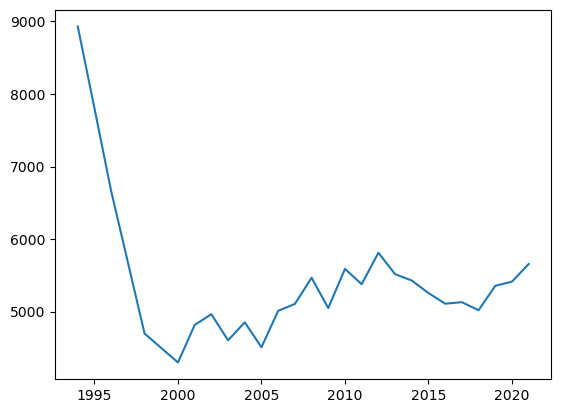

In [57]:
x=2021
pd.DataFrame({year:{'nom':f_cost[year].mean(),'real':deflated_food(year, x).mean()} for year in only_income.keys()}).T.real.plot()

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import plottools

# fig,ax = plt.subplots()

# >>> ax.plot(x,y)
# >>> ax_zoom = plottools.zoom_axes(fig,ax,[0.1,0.2],[0.8,0.9],[0.6,0.9],[0.6,0.9])
# >>> ax_zoom.plot(x,y)
# >>> plt.show()

ModuleNotFoundError: No module named 'plottools'

## Среднедушевые доходы населения и структура дохода пл квантильным группам

In [ ]:
nfm_inc={}
for key in RENAMED_HH_DFS.keys():
    nfm_inc[key]=readrlms.full_preprocessing(RENAMED_HH_DFS[key],['f14', 'nfm'])

In [ ]:
(nfm_inc[2012].f14/nfm_inc[2012].nfm).quantile(q=[0.2,0.4,0.6,0.8])

In [ ]:
def child_counter(year, age):
    fm_columns=[f'b{num}.5' for num in range(1,25)]
    df=readrlms.drop_no_ans(RENAMED_HH_DFS[year].loc[:,set(RENAMED_HH_DFS[year].columns).intersection(set(fm_columns))], by=None)
    df=pd.DataFrame(((df.astype(float)-age)>-age).sum(axis=1),columns=['nch'])
    return df

In [ ]:
fert_dict={year: child_counter(year, 18).mean().nch for year in RENAMED_HH_DFS.keys()}

In [ ]:
pd.Series(fert_dict).plot()
plt.grid()
plt.xticks(list(range(1994,2022))[::2], fontsize=8)
plt.xlabel('Год')
plt.ylabel('Среднее число детей в семье (<18)')

## Деление на продукты питания и остальные товары

In [ ]:
income_food_cost

In [ ]:
readrlms.wave_scanner(['e17'],where='hh')

In [ ]:
income_sav_food_cost={}
for key in RENAMED_HH_DFS.keys():
    income_sav_food_cost[key]=readrlms.full_preprocessing(RENAMED_HH_DFS[key],
                                                      ['f14', 'e17']).join(pd.DataFrame(aids.food_df(readrlms.FAST_HH_DFS[key],
                                                                                              'cost').sum(axis=1)/7*30,
                                                                                 columns=['food_cost']),how='right')

In [ ]:
((income_sav_food_cost[2021].fillna(0).f14-income_sav_food_cost[2021].fillna(0).e17-income_sav_food_cost[2021].fillna(0).food_cost))

Нам нужны агрегированные ценц продуктов питания и остальных товаров

Таак мы можем получить эластичности спроса и замещения для продуктов питания и для прочих товаров. 

In [ ]:
aids.AIDS_matrix(readrlms.FAST_HH_DFS[2021])

Что надо сделать:
1. Взять доход и посчитать остаток от него

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2021], 'cost').mean()

In [ ]:
food_cpi={year-1:aids.food_df(readrlms.FAST_HH_DFS[year], 'price').mean().sum()/(aids.food_df(readrlms.FAST_HH_DFS[year-1], 'price').mean().sum() for year in range(2001,2022)}

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2021], 'price').mean()*aids.food_df(readrlms.FAST_HH_DFS[2021], 'quant').mean()

In [ ]:
food_price={year: (aids.food_df(readrlms.FAST_HH_DFS[year], 'cost').divide(aids.food_df(readrlms.FAST_HH_DFS[year], 'cost').sum(axis=1),axis=0)*aids.food_df(readrlms.FAST_HH_DFS[year], 'price').fillna(0)).sum(axis=1) for year in readrlms.FAST_HH_DFS.keys()}

In [ ]:
food_agr_price={year:food_price[year].mean() for year in readrlms.FAST_HH_DFS.keys()}

In [ ]:
(pd.Series(food_agr_price).pct_change()+1)*100

In [ ]:
cpi_df[0].astype(float)-(pd.Series(food_agr_price).pct_change()+1)*100

In [ ]:
food_price[2021].mean()

In [ ]:
cpi_df

In [ ]:
pd.Series(food_cpi).pct_change()+1

In [ ]:
(aids.food_df(readrlms.FAST_HH_DFS[2021], 'cost').divide(aids.food_df(readrlms.FAST_HH_DFS[2021], 'cost').sum(axis=1),axis=0)*aids.food_df(readrlms.FAST_HH_DFS[2021], 'price').fillna(0)).sum(axis=1).mean()

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2021], 'price')

In [ ]:
df['sales'] / df.groupby('state')['sales'].transform('sum')

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2021], 'cost').mean()

In [ ]:
readrlms.FAST_HH_DFS.keys()

In [ ]:
pd.Series(food_cpi).plot()

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2021], 'price').mean().sum()/aids.food_df(readrlms.FAST_HH_DFS[2020], 'price').mean().sum()

In [ ]:
1.10*0.4

ИПЦ продуктов питания
Общий ИПЦ
ИПЦ всех остальных товаров потребеления

**Прочие товары:**

E7.11 В течение последних 12 месяцев Ваша семья покупала товары
длительного пользования - телевизор, мобильный телефон,
холодильник, мебель и тому подобное?



## Устранение проблемы 2018=2019

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2018], 'price').mean()

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2019], 'price').mean()

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2018], 'price', verbose=False).mean()

In [ ]:
aids.food_df(2019, 'price', verbose=False, path=r'C:\Users\79618\Downloads').mean()

In [ ]:
aids.food_df(2018, 'price', verbose=False, path=r'C:\Users\79618\Downloads').mean()

In [ ]:
aids.food_df(2017, 'price', verbose=False).mean()

In [ ]:
readrlms.download_rlms_db()

In [ ]:
readrlms.FAST_variable_hh(verbose=False)

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2018], 'price', verbose=False).mean()

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2019], 'price', verbose=False).mean()

Мы можем задать индекс цен для прочих товаров в некоторый год как единичный. 

## 

In [ ]:
import RLMS_HSE.reading as readrlms
import RLMS_HSE.AIDS as aids

In [ ]:
readrlms.FAST_variable_hh(verbose=False)

In [ ]:
print(aids.food_df.__doc__)

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2021], 'cost', contradict=True)

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2020], 'cost', contradict=True, add_features=['f14'])

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2020], 'cost', add_features=['f14']).f14

In [ ]:
xxx=list(aids.food_codebook.keys())
xxx.append('f14')
xxx

In [ ]:
readrlms.full_preprocessing(readrlms.FAST_HH_DFS[2020], 'cost'))

In [ ]:

len(aids.food_df(readrlms.FAST_HH_DFS[2020], 'cost').loc[aids.food_df(readrlms.FAST_HH_DFS[2020], 'cost').sum(axis=1)==0])

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2020], 'cost')

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2020], 'price')

In [ ]:
(aids.food_agregates(readrlms.FAST_HH_DFS[2021], 'cost').sum(axis=1)==0).any()

In [ ]:
xxxxxx={year:{'До чистки': len(aids.food_df(readrlms.FAST_HH_DFS[year], 'cost', contradict=1)), 
'Нет "НЕТ ОТВЕТА"':len(aids.food_df(readrlms.FAST_HH_DFS[year], 'cost')), 
'Нет нулевых агрегатов':len(aids.food_agregates(readrlms.FAST_HH_DFS[year], 'price'))} for year in readrlms.FAST_HH_DFS.keys()}

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[year], 'cost', contradict=1)

In [ ]:
RENAMED_HH_DFS={year:readrlms.columns_renamer(readrlms.FAST_HH_DFS[year]) for year in readrlms.FAST_HH_DFS.keys()}

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2020], 'cost').sum(axis=1)!=0

In [ ]:
import pandas as pd

In [ ]:
income_food_cost={}
for key in RENAMED_HH_DFS.keys():
    income_food_cost[key]=readrlms.full_preprocessing(RENAMED_HH_DFS[key],
                                                      ['f14']).fillna(0).join(pd.DataFrame(aids.food_df(readrlms.FAST_HH_DFS[key],
                                                                                              'cost').sum(axis=1)/7*30,
                                                                                 columns=['food_cost']),how='inner')

In [ ]:
income_food_cost[2020]

In [ ]:
readrlms.full_preprocessing(RENAMED_HH_DFS[2020], ['f14'])==0)

In [ ]:
delta_finres_food[2021].loc[delta_finres_food[2021]>=0].loc[finres_food_cost[2021].food_cost!=0]

In [ ]:
income_lens={year:{'До чистки': len(RENAMED_HH_DFS[year]),
                   'Чистка от "НЕТ ОТВЕТА"': len(finres_food_cost[year]),
                   'От отрицательных остатков и нулевых расходов': len(delta_finres_food[year].loc[delta_finres_food[year]>=0].loc[finres_food_cost[year].food_cost!=0])} for year in RENAMED_HH_DFS.keys()}

In [ ]:

pd.DataFrame(income_lens).T

In [ ]:
pd.DataFrame(xxxxxx)

In [ ]:
import matplotlib.ticker as mtick
data=pd.DataFrame(xxxxxx).T
ax = data.plot(kind='line', figsize=(10,5),style='-o')
ax.grid()
ax.set_xlabel('Год', fontweight='bold')
ax.set_ylabel('Размер выборки (по агрегатом продуктов)\n до и после чистки',fontweight='bold')
ax.legend(['Без чистки', 'Нет "НЕТ ОТВЕТА"', 'Нет нулевых агрегатов'], title='Процедуры чистки:')
plt.xticks(rotation=70)
ax.set_xticks(range(1994,2022),rotation=135)
ax.set_yticks(range(500,7000, 500),rotation=135)

In [ ]:
import matplotlib.ticker as mtick
data=pd.DataFrame(income_lens).T
ax = data.plot(kind='line', figsize=(10,5), style='-o')
ax.grid()
ax.set_xlabel('Год', fontweight='bold')
ax.set_ylabel('Размер выборки (по располагаемых ресурсам)\n до и после чистки',fontweight='bold')
ax.legend(['Без чистки', 'Нет "НЕТ ОТВЕТА"', 'Нет отрицательных остатков и нулей'], title='Процедуры:')
plt.xticks(rotation=70)
ax.set_xticks(range(1994,2022),rotation=135)

In [ ]:
aids.food_df(readrlms.FAST_HH_DFS[2020], 'cost', contradict=1)

In [ ]:
ttttt={year:aids.food_agregates(readrlms.FAST_HH_DFS[year],'share').mean().to_dict()for year in readrlms.FAST_HH_DFS.keys()}

In [ ]:
list(pd.DataFrame(ttttt).T.to_dict()['Бакалея'].values())

In [ ]:
ffff={column:list(pd.DataFrame(ttttt).T.to_dict()[column].values()) for column in pd.DataFrame(ttttt).T.to_dict().keys()}

In [ ]:
ffff


In [ ]:
ttttt

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.stackplot(ttttt.keys(), ffff.values(),
             labels=ffff.keys(), alpha=1)


ax.set_title('')
ax.set_xlabel('Год',fontweight='bold')
ax.set_ylabel('Средняя доля агрегата \nв расходах на продукты питания',fontweight='bold')
ax.legend(loc='best', bbox_to_anchor=(0.85, 0.5, 0.5, 0.5))
plt.xticks(rotation=70)
ax.set_xticks(range(1994,2022),rotation=135)
plt.xlim(1994,2021)
plt.ylim(0,1)
plt.grid()
plt.show()

In [ ]:
aids.food_agregates(readrlms.FAST_HH_DFS[year],'share').mean().to_dict()

In [ ]:
,
{'price':aids.food_agregates(readrlms.FAST_HH_DFS[year],'price').mean()}

In [ ]:
zz=pd.read_excel('output.xlsx','Sheet1')

In [ ]:
zz


In [ ]:
zz


In [ ]:
zz=zz.iloc[:,1:]

In [ ]:
dd=pd.DataFrame()
for i in zz.index:
    dd.loc[i.split(',')[0],i.split(',')[1] ]=zz.loc[i]['R_coef']

In [ ]:
dsts=pd.DataFrame()
for i in zz.index:
    dsts.loc[i.split(',')[0],i.split(',')[1] ]=zz.loc[i]['std']

In [ ]:
qweqwe=pd.DataFrame()
for i in zz.index:
    qweqwe.loc[i.split(',')[0],i.split(',')[1] ]=zz.loc[i]['P>|z|']

In [ ]:
dsts

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
dd

In [ ]:
dd.iloc[:,:-2]

In [ ]:
qweqwe

In [ ]:
qaz=[['-0.0421***\n(0.0098)','0.0002\n(0.0034)','0.0172***\n(0.0063)','0.0011\n(0.0055)','0.0221***\n(0.0054)','-0.0054\n(0.0033)','-0.0003\n(0.0032)'],
['0.0177**\n(0.0110)','0.0084***\n(0.0037)','0.0023\n(0.0071)','0.0043\n(0.0060)','0.0029\n(0.0059)','0.0031***\n(0.0036)','0.0066\n(0.0035)'],
['0.0665***\n(0.0125)','0.0054\n(0.0042)','-0.0077\n(0.0073)','0.0026\n(0.0071)','0.0142***\n(0.0061)','0.0108***\n(0.0039)','-0.0006\n(0.0037)'],
['0.0002\n(0.0105)','0.0035\n(0.0035)','0.0131***\n(0.006)','0.0167***\n(0.0059)','0.0016\n(0.0054)','0.0019\n(0.0034)','0.0025\n(0.0034)'],
['0.0199**\n(0.0126)','0.0018\n(0.0043)','0.0133***\n(0.0077)','0.0176***\n(0.0072)','0.0079\n(0.0064)','0.0085***\n(0.0040)','0.0016\n(0.0040)'],
['0.0326***\n(0.0120)','0.0005\n(0.0043)','0.0092\n(0.0076)','0.0052***\n(0.0066)','0.0110***\n(0.0065)','0.0109\n(0.0039)','-0.0064**\n(0.0037)'],
['0.0004\n(0.0037)','0.0003\n(0.0012)','0.0033**\n(0.0023)','0.0008\n(0.0020)','0.0076\n(0.0019)','0.0008\n(0.0011)','0.0046\n(0.0012)']]

In [ ]:
0.0098	0.0034	0.0063	0.0055	0.0054	0.0033	0.0032
0.0110	0.0037	0.0071	0.0060	0.0059	0.0036	0.0035
0.0125	0.0042	0.0073	0.0071	0.0061	0.0039	0.0037
0.0105	0.0035	0.0061	0.0059	0.0054	0.0034	0.0034
0.0126	0.0043	0.0077	0.0072	0.0064	0.0040	0.0040
0.0120	0.0043	0.0076	0.0066	0.0065	0.0039	0.0037
0.0037	0.0012	0.0023	0.0020	0.0019	0.0011	0.0012

Бакалея	0.0098	0.0034	0.0063	0.0055	0.0054	0.0033	0.0032
Овощи-фрукты	0.0110	0.0037	0.0071	0.0060	0.0059	0.0036	0.0035
Мясо-рыба	0.0125	0.0042	0.0073	0.0071	0.0061	0.0039	0.0037
Молоко	0.0105	0.0035	0.0061	0.0059	0.0054	0.0034	0.0034
Кондитерские изделия	0.0126	0.0043	0.0077	0.0072	0.0064	0.0040	0.0040
Алкоголь	0.0120	0.0043	0.0076	0.0066	0.0065	0.0039	0.0037
Неалкогольные напитки	0.0037	0.0012	0.0023	0.0020	0.0019	0.0011	0.0012

Бакалея	0.0098	0.0034	0.0063	0.0055	0.0054	0.0033	0.0032
Овощи-фрукты	0.0110	0.0037	0.0071	0.0060	0.0059	0.0036	0.0035
Мясо-рыба	0.0125	0.0042	0.0073	0.0071	0.0061	0.0039	0.0037
Молоко	0.0105	0.0035	0.0061	0.0059	0.0054	0.0034	0.0034
Кондитерские изделия	0.0126	0.0043	0.0077	0.0072	0.0064	0.0040	0.0040
Алкоголь	0.0120	0.0043	0.0076	0.0066	0.0065	0.0039	0.0037
Неалкогольные напитки	0.0037	0.0012	0.0023	0.0020	0.0019	0.0011	0.0012

In [ ]:
dsts.iloc[:,:-2]

In [ ]:
asd=[]
for i in len(dd):
    asd.append([])
    for j in len(dsts):
        asd[i][j]
        str(dd.iloc[:,-2:-1].iloc[i].values[0])[0:7]+'***'+'\n'+'('+str(dsts['Расходы'].iloc[i])[0:7]+')'] for i in range(0,7)]

In [ ]:
dsts.iloc[:,:-2] range(0,7)

In [ ]:
import seaborn as sns
sns.color_palette("viridis", as_cmap=True)
sns.heatmap(dd.iloc[:,:-2],cmap="vlag", annot=qaz, center=0, annot_kws={'size': 9}, fmt='')


In [ ]:
dd.iloc[:,-2:-1].loc['Мясо-рыба']

In [ ]:
dd

In [ ]:
dd['Расходы']['Мясо-рыба']=0.07657777777777777

In [ ]:
dd.iloc[:,-2:-1].loc['Мясо-рыба']=0.0766

In [ ]:
dd

In [ ]:
dd.iloc[:,-2:-1].iloc[0].values[0]

In [ ]:
dsts['Расходы'].iloc[0]

In [ ]:
dddddd=[[str(dd.iloc[:,-2:-1].iloc[i].values[0])[0:7]+'***'+'\n'+'('+str(dsts['Расходы'].iloc[i])[0:7]+')'] for i in range(0,7)]

In [ ]:
dddddd2=[[str(dd.iloc[:,-1:].iloc[i].values[0])[0:7]+'\n'+'('+str(dsts['const'].iloc[i])[0:7]+')'] for i in range(0,7)]

In [ ]:
dddddd2

In [ ]:
qweqwe[qweqwe==0]=qweqwe[qweqwe==0].replace(0,'***')

In [ ]:
qweqwe[qweqwe<0.1]=qweqwe[qweqwe<0.1].replace('**')

In [ ]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(1,2)
sns.color_palette("viridis", as_cmap=True)
sns.heatmap(dd.iloc[:,-2:-1],cmap="vlag", annot=dddddd, center=0, annot_kws={'size': 12},ax=ax[0], fmt='')
sns.heatmap(dd.iloc[:,-1:],cmap="vlag", annot=dddddd2, center=0, annot_kws={'size': 12},ax=ax[1], yticklabels=False, fmt='')

In [ ]:
ssss=pd.DataFrame()
ssss.loc['fdsfsd','fsdf']=0
ssss

In [ ]:
'Бакалея,Бакалея'.split(',')

In [ ]:
g=0
for i in range(2002,2022):
    g=g+len(aids.AIDS_matrix(readrlms.FAST_HH_DFS[i]))

In [ ]:
g

In [ ]:
import numpy as np
data = np.array([[0.000000,0.000000],[-0.231049,0.000000],[-0.231049,0.000000]])
labels =  np.array([['A','B'],['C','D'],['E','F']])
fig, ax = plt.subplots()
ax = sns.heatmap(data, annot = labels, fmt = '')

## Codebook

In [ ]:
codebook_of_ind_codes=pd.read_spss('Codebook_БД_ind_USER_1994_2021.sav')

In [ ]:
def ind_codebook(codes):
    if type(codes)==list:
        return {codebook_of_ind_codes.loc[codebook_of_ind_codes.name==code].name.values[0]: codebook_of_ind_codes.loc[codebook_of_ind_codes.name==code].variable_labels.values[0] for code in codes}
    if type(codes)==str:
        return {codebook_of_ind_codes.loc[codebook_of_ind_codes.name==codes].name.values[0]: codebook_of_ind_codes.loc[codebook_of_ind_codes.name==codes].variable_labels.values[0]}
    

## Реальные расходы по категориям

КИПЦ - Классификация расходов по целям. 
Классификация расходов на индивидуальное потребление домашних хозяйств:
1. Продукты питания и безалкогольные напитки
2. Алкогольные напитки, табачные изделияи наркотические средства 
3. Одежда и обувь
4. Жилищные услуги, вода, электричество, газ и дургие виды топлива
5. Предметы домашнего обихода, бытовая техника и текущее обслуживание жилья
6. Здравоохранение
7. Транспорт
8. Связь
9. Отдых и культура
10. Образование
11. Рестораны и гостиницы 
12. Разные товары и услуги

**Частное хозяйство:**
* D1 В течение последних 12 месяцев у Вашей семьи была в
пользовании какая-либо земля?
* D2 В настоящее время у Вашей семьи есть в пользовании какаялибо земля?
* D6 Сколько всего рублей Вы заплатили за пользование Вашей
землей в последние 12 месяцев?

**Продукты питания:**
* E1

E3 Вспомните, сколько примерно денег все члены Вашей семьи
израсходовали на питание вне дома в течение последних 7
дней?

E4 Вспомните, сколько примерно денег все члены Вашей семьи
израсходовали на питание дома и вне дома в течение
последних 30 дней?


E6 Сколько Вы и дpугие члены домохозяйства заплатили за
одежду или обувь для членов домохозяйства в течение
последних 3-х месяцев?

E6.1 Сколько Вы и другие члены домохозяйства потратили на
приобретение одежды и обуви для взрослых, то есть для
членов домохозяйства 18-ти лет и старше, в течение
последних 3 месяцев?

E6.2 Сколько Вы и другие члены домохозяйства потратили на
приобретение одежды и обуви для детей, то есть для членов
домохозяйства младше 18-ти лет, в течение последних 3
месяцев?

E7.1B Сколько всего рублей Вы заплатили за культтовары:
телевизор, магнитофон, видео, музыкальные инструменты и
тому подобное? (3 месяца)

E7.1.0B Сколько всего рублей Ваша семья заплатила за культтовары:
телевизор, магнитофон, видео, музыкальные инструменты,
компьютер, фотоаппарат и тому подобное? (3 месяца)

E7.1.1B Сколько всего рублей Ваша семья заплатила за мобильный
телефон? (3 месяца)

E7.2B Сколько всего рублей Ваша семья заплатила за предметы
домашней обстановки: мебель, ковры и другое? (3 месяца)

E7.3B Сколько всего рублей Ваша семья заплатила за бытовую
технику: холодильник, стиральную машину, пылесос, швейную
машину, утюг, кухонный комбайн и тому подобное? (3 месяца)

E7.4B Сколько всего рублей Ваша семья заплатила за автомобиль
или микроавтобус? (3 месяца)

E7.5B Сколько всего рублей Ваша семья заплатила за мотоцикл,
мотороллер и тому подобное? (3 месяца)

E7.6B Сколько всего рублей Ваша семья заплатила за гараж? (3 месяца)

E7.7B Сколько всего рублей Ваша семья заплатила за строительные
материалы, материалы для ремонта? (3 месяца)

E7.8B Сколько всего рублей Ваша семья заплатила за дом, дачу,
квартиру, землю? (3 месяца)

E7.9B Сколько всего рублей Ваша семья заплатила за книги,
учебники, учебные пособия, канцтовары? (3 месяца)

E7.10B Сколько всего рублей Ваша семья заплатила за
спортинвентарь: велосипед, самокат, коньки? (3 месяца)



E8.1B Сколько всего рублей Ваша семья заплатила за топливо для заправки автотранспорта, двигателей, генераторов? (30 дней)

E8.2B Сколько всего рублей Ваша семья заплатила за дрова, уголь, торф, керосин? (30 дней)

E8.3B Сколько всего рублей Ваша семья заплатила за баллонный газ? (30 дней)

E9.1B Сколько всего рублей Ваша семья заплатила за услуги транспорта: местного, междугороднего? (30 дней)

E9.2B Сколько всего рублей Ваша семья заплатила за услуги по пошиву и ремонту одежды, обуви? (30 дней)

E9.3B Сколько всего рублей Ваша семья заплатила за услуги мастерских по ремонту культтоваров, например телевизора, магнитофона или мебели, бытовой техники, включая покупку запчастей? (30 дней)

E9.4B Сколько всего рублей Ваша семья заплатила за услуги по ремонту и строительству жилья, построек? (30 дней)

E9.4.1B Сколько всего рублей Ваша семья заплатила за услуги по ремонту автомобиля, мотоцикла, включая покупку запчастей? (30 дней)

E9.5B Сколько всего рублей Ваша семья заплатила за услуги прачечной, химчистки, бани, парикмахерской? (30 дней)

E9.6B Сколько всего рублей Ваша семья заплатила за почтовотелеграфные услуги, включая междугородные телефонные переговоры? (30 дней)

E9.7B Сколько всего рублей Ваша семья заплатила за ритуальные услуги: загс, похоронное бюро? (30 дней)

E9.8B Сколько всего рублей Ваша семья заплатила за услуги мобильной сотовой связи? (30 дней)

E9.9B Сколько всего рублей Ваша семья заплатила за услуги Интернета? (30 дней)

E9.10B Сколько всего рублей Ваша семья заплатила за услуги юристов, нотариусов, риэлторов? (30 дней)

9.11B Сколько всего рублей Ваша семья заплатила за услуги кабельного и спутникового телевидения? (30 дней)

E11 Сколько рублей Ваша семья фактически заплатила в течение последних 30 дней за квартиру, включая аренду, и коммунальные услуги? (30 дней)

E12.2 Если вспомнить последние 3 месяца, сколько рублей в
среднем в месяц должна была платить Ваша семья за
квартиру, включая аренду, и коммунальные услуги, за
вычетом субсидий и льгот, если они у Вас есть?

E13.1B Сколько всего рублей Ваша семья истратила на содержание и
оплату занятий детей в дошкольных учреждениях, школах,
секциях, кружках, на оплату частных уроков, репетиторов,
в том числе и на подарки педагогам? (30 дней)

E13.2B Сколько всего рублей Ваша семья истратила на путевки в
санатории, дома отдыха, детские лагеря, на туристические
поездки и другое, исключая расходы на транспорт? (30 дней)

E13.21B Сколько всего рублей Ваша семья истратила на билеты: в
театр, цирк, кино, на концерты, в парки культуры и другие
развлекательные мероприятия? (30 дней)

E13.22B Сколько всего рублей Ваша семья истратила на лечение,
обследование в стационарных лечебных учреждениях:
больницах, госпиталях, клиниках, исключая покупку
лекарств? (30 дней)

E13.23B Сколько всего рублей Ваша семья истратила на лечение,
обследование в поликлиниках, амбулаториях, исключая
покупку лекарств? (30 дней)

E13.24B Сколько всего рублей Ваша семья истратила на лечение,
протезирование зубов, исключая покупку лекарств? (30 дней)

E13.3B Сколько всего рублей Ваша семья истратила на лечение,
обследование, исключая покупку лекарств? (30 дней)

E13.31B Сколько всего рублей Ваша семья истратила на лекарства,
включая витамины и другие медикаменты? (30 дней)

E13.32B Сколько всего рублей Ваша семья истратила на моющие
средства, например, хозяйственное мыло, стиральный
порошок и другие? (30 дней)

E13.33B Сколько всего рублей Ваша семья истратила на средства
личной гигиены, например, туалетное мыло, шампунь, зубную
пасту, туалетную бумагу, салфетки, памперсы, прокладки? (30 дней)

E13.34B Сколько всего рублей Ваша семья истратила на косметику и
парфюмерию? (30 дней)

E13.35B Сколько всего рублей Ваша семья истратила на содержание
домашних животных? (30 дней)

E13.4B Сколько всего рублей Ваша семья истратила оплату занятий
взрослых членов семьи в различных секциях, на курсах, у
преподавателей? (30 дней)

E13.5B Сколько всего рублей Ваша семья истратила на приобретение
акций, облигаций, других ценных бумаг? (30 дней)

E13.6B Сколько всего рублей Ваша семья истратила на уплату любых
страховых взносов: за страхование жизни, здоровья,
машины, жилища и другого? (30 дней)

E13.7B Сколько всего рублей Ваша семья истратила на погашение
кредита, возврат ссуд, уплату долгов? (30 дней)

E13.71B Сколько всего рублей Ваша семья истратила на уплату
долгов частным лицам?

E13.72B Сколько всего рублей Ваша семья истратила на погашение
кредита, возврат ссуд?

E13.8B Сколько всего рублей Ваша семья истратила на уплату
алиментов?

E13.11B Сколько всего рублей Ваша семья истратила на оплату
аренды дачи, земли?

E13.12B Сколько всего рублей Ваша семья истратила на оплату
стоянки транспорта, аренду гаража?

E13.13B Сколько всего рублей Ваша семья истратила на уплату
членских взносов в дачных, гаражных кооперативах,
общественных или профессиональных организациях?

E13.9B Сколько всего рублей Ваша семья истратила на уплату
налогов на недвижимость и транспорт, оплату лицензии,
пошлин за оформление справок и виз, бланков документов,
кроме налогов на доходы и землю?

E13.10B Сколько всего рублей Ваша семья истратила на покупку
валюты с целью сбережений?

**Образование:**

F20.1B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на на платежи за обучение в
частной школе - на основе официального договора или
другого финансового документа?

F20.2B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на дополнительные занятия в
государственной школе?

F20.3B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на занятия с репетиторами в
государственной или частной школе и(или) вне школы, кроме
подготовки к поступлению в ВУЗы и техникумы?

F20.4B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на взносы, сборы,
пожертвования в помощь учебному заведению, например, на
охрану, ремонт, покупку школьного оборудования?

F20.5B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на подарки в виде товаров
или денег учителям и другим работникам учебного
заведения?

F20.6B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на что-то еще, связанное с
обучением членов домохозяйства в общеобразовательной
школе?

F23.1B Сколько всего в рублях в течение последних 12 месяцев
Ваше д/х истратило на обучение в част. учебном заведении
или на платной основе в гос.учебном заведении на основе
официального договора или другого финансового документа?

F23.2B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату факультативных
предметов в государственном учебном заведении при
обучении на бесплатной основе?

F23.3B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на занятия с репетиторами в
частном или государственном учебном заведении и(или) вне
его, кроме подготовки к поступлению в ВУЗы и техникумы?

F23.4B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату сдачи и пересдачи
экзаменов, зачетов, курсовых и дипломных работ?

F23.5B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на взносы, сборы,
пожертвования в помощь учебному заведению, например, на
охрану, ремонт, покупку оборудования?

F23.6B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на подарки в виде товаров
или денег преподавателям и другим работникам учебного
заведения?

F23.7B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату общежития или
снимаемого жилья?

F23.8B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на что-то еще, связанное с
обучением членов домохозяйства в ПТУ или среднем
специальном учебном заведении?

F26.1B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на платежи за обучение в
частном ВУЗе или на платной основе в государственном ВУЗе
- на основе официального договора или другого финансового
документа?

F26.2B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату факультативных
предметов в государственном ВУЗе при обучении на
бесплатной основе?

F26.3B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на занятия с репетиторами в
частном или государственном ВУЗе или вне его?

F26.4B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату сдачи и пересдачи
экзаменов, зачетов, курсовых и дипломных работ?

F26.5B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на взносы, сборы,
пожертвования в помощь учебному заведению, например, на
охрану, ремонт, покупку оборудования?

F26.6B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на подарки в виде товаров
или денег преподавателям и другим работникам учебного
заведения?

F26.7B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату общежития или
снимаемого жилья?

F26.8B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на что-то еще, связанное с
обучением членов домохозяйства в высшем учебном
заведении?

F28.1B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на приобретение
дополнительных учебников, справочников?

F28.2B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на занятия с репетиторами?

F28.3B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату дополнительных
курсов?

F28.4B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на благодарность в виде
товаров или денег за помощь в поступлении?

F28.5B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на оплату общежития или
снимаемого жилья во время экзаменов?

F28.7B Сколько всего в рублях в течение последних 12 месяцев
Ваше домохозяйство истратило на проезд до места
поступления?

F33 Какую именно сумму Ваша семья за последние 12 месяцев
потратила на обучение в среднем-специальном или высшем
учебном заведении? Суммируйте расходы по всем членам
домохозяйства?

F36 Какую сумму Ваша семья потратила на обучение в среднемспециальном учебном заведении за последние 12 месяцев?
Суммируйте расходы по всем, кто учился в среднем-специальном учебном заведении

F39 Какую сумму Ваша семья потратила на обучение в высшем
учебном заведении за последние 12 месяцев? Суммируйте
расходы по всем, кто учился в высшем учебном заведении

H2421.1 Оцените в рублях Ваши затраты на вступительный взнос,
который требовался для поступления 1-го ребенка в (эти
ясли/этот детский сад/эту школу)

H2421.2 Оцените в рублях Ваши затраты на оплату подготовительных
курсов в (яслях/детском саду/школе) для поступления 1-го
ребенка в (эти ясли/этот детский сад/эту школу)

.x

H2422.1 Оцените в рублях Ваши затраты на вступительный взнос, который требовался для поступления 2-го ребенка в (эти
ясли/этот детский сад/эту школу)

H2422.2 Оцените в рублях Ваши затраты на оплату подготовительных
курсов в (яслях/детском саду/школе) для поступления 2-го
ребенка в (эти ясли/этот детский сад/эту школу)

H26.1 Ваша семья платила за учебники и учебные пособия, по
которым 1-й ребенок занимается в этом учебном году? Если
да, то сколько Вы заплатили?

H26.2 Ваша семья платила за учебники и учебные пособия, по
которым 2-й ребенок занимается в этом учебном году? Если
да, то сколько Вы заплатили?

H27.1 Кроме затрат на учебники, Ваша семья тратила что-нибудь
на подготовку 1-го ребенка к учебному году: канцтовары,
необходимую одежду, обувь и проч. обязательные вещи? Если
да, то сколько Вы потратили на все это?

H27.2 Кроме затрат на учебники, Ваша семья тратила что-нибудь
на подготовку 2-го ребенка к учебному году: канцтовары,
необходимую одежду, обувь и проч. обязательные вещи? Если
да, то сколько Вы потратили на все это?

H29.1 Сколько рублей в среднем Вы платите за месяц (пребывание
в яслях/дет.саду/за обучение по основной программе в
школе) 1-го ребенка на основании договора или любого
другого официального документа?

H29.2 Сколько рублей в среднем Вы платите за месяц (пребывание
в яслях/дет.саду/за обучение по основной программе в
школе) 2-го ребенка на основании договора или любого
другого официального документа?

H31.1 Сколько рублей в среднем за месяц обучения Вы платите за
1-го ребенка за дополнительные занятия по учебным
предметам в (дет.саду/школе)?

H31.2 Сколько рублей в среднем за месяц обучения Вы платите за
2-го ребенка за дополнительные занятия по учебным
предметам в (дет.саду/школе)?

H3331.2 Сколько рублей в среднем Вы платите за месяц
необязательных дополнительных занятий по учебным
предметам в другом учреждении за 1-го ребенка?

H3331.3 Сколько рублей в среднем Вы платите за месяц
необязательных дополнительных занятий по учебным
предметам с репетиторами, частными преподавателями за 1-
го ребенка?

H3332.1 Сколько рублей в среднем Вы платите за месяц
необязательных дополнительных занятий по учебным
предметам в (Вашем детском саду/Вашей школе) за 2-го
ребенка?

H34.1 В текущем учебном году Ваша семья делает денежые взносы,
пожертвования в помощь (яслям/дет.саду/школе), которые
посещает 1-й ребенок? Если да, то сколько рублей в
среднем Вы платите за меся

H34.2 В текущем учебном году Ваша семья делает денежые взносы,
пожертвования в помощь (яслям/дет.саду/школе), которые
посещает 2-й ребенок? Если да, то сколько рублей в
среднем Вы платите за месяц?

H35.1 В текущем учебном году Ваша семья оказывает материальную
помощь в неденежной форме (яслям/дет.саду/школе), которые
посещает 1-й ребенок? Если да, то оцените в рублях размер
этой помощи в среднем за месяц

H35.2 В текущем учебном году Ваша семья оказывает материальную
помощь в неденежной форме (яслям/дет.саду/школе), которые
посещает 2-й ребенок? Если да, то оцените в рублях размер
этой помощи в среднем за месяц

H382.1 Cколько рублей в среднем Вы платите за питание за месяц
обучения, учитывая завтраки, полдники, обеды, ужины? За
1-го ребенка

H382.2 Cколько рублей в среднем Вы платите за питание за месяц
обучения, учитывая завтраки, полдники, обеды, ужины? За
2-го ребенка

H392.1 Сколько рублей в среднем в месяц Вы платите за экскурсии,
праздники и другие мероприятия, проводимые в
(яслях/детском саду/школе), которые посещает 1-й ребенок?

H392.2 Сколько рублей в среднем в месяц Вы платите за экскурсии,
праздники и другие мероприятия, проводимые в
(яслях/детском саду/школе), которые посещает 2-й ребенок?

H40.1 Ваша семья делает денежные и иные подарки работникам
(дет.сада/школы), которые посещает 1-й ребенок, в т.ч. и
за особое внимание к ребенку? Если да, то сколько рублей
в среднем Вы тратите на это за месяц?

H40.2 Ваша семья делает денежные и иные подарки работникам
(дет.сада/школы), которые посещает 2-й ребенок, в т.ч. и
за особое внимание к ребенку? Если да, то сколько рублей в среднем Вы тратите на это за месяц?

H41.1 Ваша семья платит кому-нибудь за помощь 1-му ребенку в
выполнении домашних заданий или подготовке письменных
работ? Если да, то сколько рублей в среднем Вы платите за
месяц обучения?

H41.2 Ваша семья платит кому-нибудь за помощь 2-му ребенку в
выполнении домашних заданий или подготовке письменных
работ? Если да, то сколько рублей в среднем Вы платите за
месяц обучения?

H4231.1 Сколько рублей в среднем Вы платите за месяц
дополнительных творческих или любительских занятий 1-го
ребенка в (Вашем саду/Вашей школе)?

H4231.2 Сколько рублей в среднем Вы платите за месяц
дополнительных творческих или любительских занятий 1-го
ребенка в других учреждениях (в кружках, клубах, секциях,
специализированных школах)?

H4231.3 Сколько рублей в среднем Вы платите за месяц дополнительных творческих или любительских занятий 1-го
ребенка с частным преподавателем, репетитором?

H4331.2 Сколько рублей в среднем Вы платите за месяц
дополнительных занятий спортом 1-го ребенка в другом
учреждении (в спортивной школе, секции, клубе, бассейне)?

H4332.2 Сколько рублей в среднем Вы платите за месяц
дополнительных занятий спортом 2-го ребенка в другом
учреждении (в спортивной школе, секции, клубе, бассейне)?

H44.1C У Вашей семьи в текущем учебном году есть еще какие-то
расходы, связанные с воспитанием и образованием 1-го
ребенка, которые мы не учли? 0 - РАСХОДОВ НЕ БЫЛО

H44.2C У Вашей семьи в текущем учебном году есть еще какие-то
расходы, связанные с воспитанием и образованием 2-го
ребенка, которые мы не учли? 0 - РАСХОДОВ НЕ БЫЛО

H5124.6 Оцените в рублях Ваши другие расходы, связанные с
поступлением 4-го учащегося в учебное заведение
профессионального образования

H53.1 Ваша семья платила за учебники, учебную и методическую
литературу для 1-го учащегося в этом учебном году? Если
да, то сколько Вы заплатили?

H54.2 (Кроме денег на учебники), Ваша семья тратила что-нибудь
на подготовку 2-го учащегося к текущему учебном году: на
канц.принадлежности и вещи, необходимые для учебного
процесса? Если да, то сколько Вы потратили на все это?

H57.1 Сколько рублей в среднем Вы платите за месяц обучения 1-
го учащегося по основной программе в учебном заведении
профессионального обучения на основании договора или
любого другого официального документа?

H582.1 Сколько рублей в среднем Вы платите за месяц обучения 1-
го учащегося за какие-нибудь дополнительные занятия для
специализации, настоятельно рекомендуемые преподавателями
учебного заведения?

H63.1 Сколько Ваша семья платит в среднем в месяц за проживание
1-го учащегося, который сейчас получает профессиональное
образование?


In [ ]:
import RLMS_HSE.reading as readrlms
from importlib import reload  # Python 3.4+
readrlms = reload(readrlms)

In [ ]:
readrlms.wave_scanner(['h49.1'],where='hh')

In [ ]:
RENAMED_HH_DFS[2010]['h49.1'].dropna()

# Первый шаг бюджетирования

## Получение фрейма данных для певрого шага бюджетирования

In [6]:
import pyreadstat
constr_df, meta = pyreadstat.read_sav('HH_1994_2021_constr_rus.sav')

In [7]:
reverse_waves_dict={'A': [1994, 5],
                    'B': [1995, 6],
                    'C': [1996, 7],
                    'D': [1998, 8],
                    'E': [2000, 9],
                    'F': [2001, 10],
                    'G': [2002, 11],
                    'H': [2003, 12],
                    'I': [2004, 13],
                    'J': [2005, 14],
                    'K': [2006, 15],
                    'L': [2007, 16],
                    'M': [2008, 17],
                    'N': [2009, 18],
                    'O': [2010, 19],
                    'P': [2011, 20],
                    'Q': [2012, 21],
                    'R': [2013, 22],
                    'S': [2014, 23],
                    'T': [2015, 24],
                    'U': [2016, 25],
                    'V': [2017, 26],
                    'W': [2018, 27],
                    'X': [2019, 28],
                    'Y': [2020, 29],
                    'Z': [2021, 30]}
double_reverse_waves_dict={reverse_waves_dict[wave][1]:[reverse_waves_dict[wave][0], wave] for wave in reverse_waves_dict.keys()}
constr_df.id_w=constr_df.id_w.astype(int).replace({i: double_reverse_waves_dict[i][0] for i in  double_reverse_waves_dict.keys()})

In [8]:
meta.column_names_to_labels

{'id_w': 'RLMS-HSE: ВОЛНА',
 'redid_h': 'НОМЕР СЕМЬИ: СПЛОШНАЯ НУМЕРАЦИЯ',
 'id_h': 'RLMS-HSE: ИДЕНТИФИКАЦИОННЫЙ НОМЕР ДОМОХОЗЯЙСТВА',
 'aid_h': 'НОМЕР СЕМЬИ В 5-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'bid_h': 'НОМЕР СЕМЬИ В 6-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'cid_h': 'НОМЕР СЕМЬИ В 7-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'did_h': 'НОМЕР СЕМЬИ В 8-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'eid_h': 'НОМЕР СЕМЬИ В 9-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'fid_h': 'НОМЕР СЕМЬИ В 10-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'gid_h': 'НОМЕР СЕМЬИ В 11-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'hid_h': 'НОМЕР СЕМЬИ В 12-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'iid_h': 'НОМЕР СЕМЬИ В 13-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'jid_h': 'НОМЕР СЕМЬИ В 14-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'kid_h': 'НОМЕР СЕМЬИ В 15-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'lid_h': 'НОМЕР СЕМЬИ В 16-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'mid_h': 'НОМЕР СЕМЬИ В 17-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'nid_h': 'НОМЕР СЕМЬИ В 18-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'oid_h': 'НОМЕР СЕМЬИ В 19-Й ВОЛНЕ: ИДЕНТИФИКАЦИОННЫЙ',
 'pid_h': 'НОМЕ

'tincm.n': 'Совокупный доход домохозяйства: номинальные (в ценах года опроса)',
 'tincm.r':

In [10]:
constr_df['tincm.r']

0         31005.42
1         24207.56
2          2652.77
3          2799.52
4         10017.18
            ...   
151901    19111.33
151902     5542.02
151903    14054.15
151904     3311.97
151905     8539.69
Name: tincm.r, Length: 151906, dtype: float64

In [11]:
constr_df=constr_df.reset_index()

## Нахождение, сводящей к нулю комбинации статей расходов

In [12]:
all_constr_cols={
 'totexpn': 'Общий объем расходов домохозяйства: номинальные (в ценах года опроса)',
 'totexpr': 'Общий объем расходов домохозяйства: реальные (в ценах 2003 года)',
 'dairyn': 'Общие расходы домохозяйства на молочные продукты: номинальные (в ценах года опроса)',
 'dairyr': 'Общие расходы домохозяйства на молочные продукты: реальные (в ценах 2003 года)',
 'meatn': 'Общие расходы домохозяйства на мясные продукты: номинальные (в ценах года опроса)',
 'meatr': 'Общие расходы домохозяйства на мясные продукты: реальные (в ценах 2003 года)',
 'fishn': 'Общие расходы домохозяйства на рыбные продукты: номинальные (в ценах года опроса)',
 'fishr': 'Общие расходы домохозяйства на рыбные продукты: реальные (в ценах 2003 года)',
 'potaton': 'Общие расходы домохозяйства на картофель: номинальные (в ценах года опроса)',
 'potator': 'Общие расходы домохозяйства на картофель: реальные (в ценах 2003 года)',
 'eatoutn': 'Общие расходы домохозяйства на обеды вне дома: номинальные (в ценах года опроса)',
 'eatoutr': 'Общие расходы домохозяйства на обеды вне дома: реальные (в ценах 2003 года)',
 'breadn': 'Общие расходы домохозяйства на хлеб: номинальные (в ценах года опроса)',
 'breadr': 'Общие расходы домохозяйства на хлеб: реальные (в ценах 2003 года)',
 'eggsn': 'Общие расходы домохозяйства на яйца: номинальные (в ценах года опроса)',
 'eggsr': 'Общие расходы домохозяйства на яйца: реальные (в ценах 2003 года)',
 'fatn': 'Общие расходы домохозяйства на сало, жиры: номинальные (в ценах года опроса)',
 'fatr': 'Общие расходы домохозяйства на сало, жиры: реальные (в ценах 2003 года)',
 'fruitsn': 'Общие расходы домохозяйства на фрукты: номинальные (в ценах года опроса)',
 'fruitsr': 'Общие расходы домохозяйства на фрукты: реальные (в ценах 2003 года)',
 'sugarn': 'Общие расходы домохозяйства на сахар: номинальные (в ценах года опроса)',
 'sugarr': 'Общие расходы домохозяйства на сахар: реальные (в ценах 2003 года)',
 'vegetn': 'Общие расходы домохозяйства на овощи: номинальные (в ценах года опроса)',
 'vegetr': 'Общие расходы домохозяйства на овощи: реальные (в ценах 2003 года)',
 'ofoodn': 'Общие расходы домохозяйства на прочие продукты: номинальные (в ценах года опроса)',
 'ofoodr': 'Общие расходы домохозяйства на прочие продукты: реальные (в ценах 2003 года)',
 'tobacn': 'Общие расходы домохозяйства на табак: номинальные (в ценах года опроса)',
 'tobacr': 'Общие расходы домохозяйства на табак: реальные (в ценах 2003 года)',
 'alcohln': 'Общие расходы домохозяйства на алкоголь: номинальные (в ценах года опроса)',
 'alcohlr': 'Общие расходы домохозяйства на алкоголь: реальные (в ценах 2003 года)',
 'clothn': 'Общие расходы домохозяйства на одежду: номинальные (в ценах года опроса)',
 'clothr': 'Общие расходы домохозяйства на одежду: реальные (в ценах 2003 года)',
 'fuelaun': 'Общие расходы домохозяйства на топливо: номинальные (в ценах года опроса)',
 'fuelaur': 'Общие расходы домохозяйства на топливо: реальные (в ценах 2003 года)',
 'fuelwdn': 'Общие расходы домохозяйства на древесину: номинальные (в ценах года опроса)',
 'fuelwdr': 'Общие расходы домохозяйства на древесину: реальные (в ценах 2003 года)',
 'fuelgsn': 'Общие расходы домохозяйства на газ: номинальные (в ценах года опроса)',
 'fuelgsr': 'Общие расходы домохозяйства на газ: реальные (в ценах 2003 года)',
 'durabn': 'Общие расходы домохозяйства на товары длительного пользования: номинальные (в ценах года опроса)',
 'durabr': 'Общие расходы домохозяйства на товары длительного пользования: реальные (в ценах 2003 года)',
 'luxurn': 'Общие расходы домохозяйства на товары престижного потребления: номинальные (в ценах года опроса)',
 'luxurr': 'Общие расходы домохозяйства на товары престижного потребления: реальные (в ценах 2003 года)',
 'healthn': 'Общие расходы домохозяйства на медицинские услуги: номинальные (в ценах года опроса)',
 'healthr': 'Общие расходы домохозяйства на медицинские услуги: реальные (в ценах 2003 года)',
 'oservcn': 'ОБЩИЕ РАСХОДЫ HH НА ОБУЧЕНИЕ И ВОСПИТАНИЕ (КРУЖКИ, СЕКЦИИ, КНИГИ), ОТДЫХ И РАЗВЛЕЧЕНИЯ (БИЛЕТЫ, ПУТЕВКИ), РЕМОНТ ДОМА\\ДАЧИ\\АВТО\\ КУЛЬТТОВАРОВ,  И Т.П.: НОМИНАЛЬНЫЕ',
 'oservcr': 'ОБЩИЕ РАСХОДЫ HH НА ОБУЧЕНИЕ И ВОСПИТАНИЕ (КРУЖКИ, СЕКЦИИ, КНИГИ), ОТДЫХ И РАЗВЛЕЧЕНИЯ (БИЛЕТЫ, ПУТЕВКИ), РЕМОНТ ДОМА\\ДАЧИ\\АВТО\\ КУЛЬТТОВАРОВ,  И Т.П.: РЕАЛЬНЫЕ',
 'servicn': 'ОБЩИЕ РАСХОДЫ HH ДОМОХОЗЯЙСТВА НА ВСЕ ВИДЫ УСЛУГ ОБСЛУЖИВАНИЯ (ВКЛЮЧАЯ МЕДИЦИНСКИЕ) РАСХОДЫ НА ЛЕЧЕНИЕ: НОМИНАЛЬНЫЕ',
 'servicr': 'ОБЩИЕ РАСХОДЫ HH ДОМОХОЗЯЙСТВА НА ВСЕ ВИДЫ УСЛУГ ОБСЛУЖИВАНИЯ (ВКЛЮЧАЯ МЕДИЦИНСКИЕ) РАСХОДЫ НА ЛЕЧЕНИЕ:РЕАЛЬНЫЕ',
 'paymntn': 'Общие расходы домохозяйства на алименты, уплату долга, кредита, страховки: номинальные (в ценах года опроса)',
 'paymntr': 'Общие расходы домохозяйства на алименты, уплату долга, кредита, страховки: реальные (в ценах 2003 года)',
 'rentun': 'Общие расходы домохозяйства на оплату квартиры и коммунальных услуг: номинальные (в ценах года опроса)',
 'rentur': 'Общие расходы домохозяйства на оплату квартиры и коммунальных услуг: реальные (в ценах 2003 года)',
 'bondsn': 'Общие расходы домохозяйства на облигации и ценные бумаги: номинальные (в ценах года опроса)',
 'bondsr': 'Общие расходы домохозяйства на облигации и ценные бумаги: реальные (в ценах 2003 года)',
 'assistn': 'Общие расходы домохозяйства на другие нужды: номинальные (в ценах года опроса)',
 'assistr': 'Общие расходы домохозяйства на другие нужды: реальные (в ценах 2003 года)',
 'miscnfn': 'Общие непродуктовые расходы домохозяйства (хоз.товары, косметика и т.п.): номинальные (в ценах года опроса)',
 'miscnfr': 'Общие непродуктовые расходы домохозяйства (хоз.товары, косметика и т.п.): реальные (в ценах 2003 года)',
 'savingn': 'Накопления домохозяйства: номинальные (в ценах года опроса)',
 'savingr': 'Накопления домохозяйства: реальные (в ценах 2003 года)',
 'hprgncn': 'Общий натуральный доход домохозяйства от выращенного, безналичные: номинальные (в ценах года опроса)',
 'hprgncr': 'Общий натуральный доход домохозяйства от выращенного, безналичные: реальные (в ценах 2003 года)',
    
    
}
#  'savingn': 'Накопления домохозяйства: номинальные (в ценах года опроса)',
#  'savingr': 'Накопления домохозяйства: реальные (в ценах 2003 года)',
#  'hprgncn': 'Общий натуральный доход домохозяйства от выращенного, безналичные: номинальные (в ценах года опроса)',
#  'hprgncr': 'Общий натуральный доход домохозяйства от выращенного, безналичные: реальные (в ценах 2003 года)',
# all_constr_cols=[i for i in all_constr_cols.keys() if i[-1]=='r']
all_constr_cols=[i for i in all_constr_cols.keys() if i[-1]=='n']

In [7]:
constr_df[all_constr_cols].columns

Index(['totexpn', 'dairyn', 'meatn', 'fishn', 'potaton', 'eatoutn', 'breadn',
       'eggsn', 'fatn', 'fruitsn', 'sugarn', 'vegetn', 'ofoodn', 'tobacn',
       'alcohln', 'clothn', 'fuelaun', 'fuelwdn', 'fuelgsn', 'durabn',
       'luxurn', 'healthn', 'oservcn', 'servicn', 'paymntn', 'rentun',
       'bondsn', 'assistn', 'miscnfn', 'savingn', 'hprgncn'],
      dtype='object')

In [13]:
(round(constr_df[all_constr_cols].fillna(0).eval('totexpn-dairyn-meatn-fishn-potaton-eatoutn-breadn-eggsn-fatn-fruitsn'+
                                         '-sugarn-vegetn-ofoodn-tobacn-alcohln-clothn'+
                                         '-fuelaun-fuelwdn-fuelgsn'+
                                         '-durabn-luxurn-oservcn-servicn-paymntn-rentun-bondsn-assistn'+
                                         '-miscnfn-savingn-hprgncn-healthn'+
                                         '+servicn+assistn'), 0)==0).value_counts()


True    151906
dtype: int64

In [14]:
(round(constr_df[all_constr_cols].fillna(0).eval('totexpn-dairyn-meatn-fishn-potaton-eatoutn-breadn-eggsn-fatn-fruitsn'+
                                         '-sugarn-vegetn-ofoodn-tobacn-alcohln-clothn'+
                                         '-fuelaun-fuelwdn-fuelgsn'+
                                         '-durabn-luxurn-oservcn-paymntn-rentun-bondsn'+
                                         '-miscnfn-savingn-hprgncn-healthn'), 0)==0).value_counts()

True    151906
dtype: int64

Обнаруженные повторы:
1. ``servicn``
2. ``assistn``

Формула, которая приравнивает к нулю сумму расходов успешно найдена. 
Теперь необходимо получить агрегаты для оценки AIDS-модели. 

**Агрегаты потребления:**
1. Продукты питания: 
2. Одежда
3. Топливо
4. Товары длительного потребления
5. Товары роскоши
6. ``oservcn`` - различные услуги (образование, развлечения, ремонт и т.д.)
7. ``miscnfn`` - прочие товары

**Обязательные расходы (не входят в потребительские расходы):**
1. ``paymntn`` - Общие расходы домохозяйства на алименты, уплату долга, кредита, страховки
2. ``rentun`` - 'Общие расходы домохозяйства на оплату квартиры и коммунальных услуг
3. ``bondsn`` - Общие расходы домохозяйства на облигации и ценные бумаги
4. ``hprgncn`` - Общий натуральный доход домохозяйства от выращенного, безналичные
5. ``savingn`` - Накопления домохозяйства

In [10]:
t='n'
constr_df[f'totcons{t}']=constr_df.fillna(0).eval(f'totexp{t}-paymnt{t}-rentu{t}-bonds{t}-hprgnc{t}-saving{t}')
constr_df[f'totfood{t}']=constr_df.fillna(0).eval(f'dairy{t}+meat{t}+fish{t}+potato{t}+eatout{t}+bread{t}+eggs{t}+fat{t}+fruits{t}+sugar{t}+veget{t}+ofood{t}+tobac{t}+alcohl{t}')
constr_df[f'totfuel{t}']=constr_df.fillna(0).eval(f'fuelau{t}+fuelwd{t}+fuelgs{t}')
constr_df[f'totcloth{t}']=constr_df.fillna(0).eval(f'cloth{t}')
constr_df[f'totdurab{t}']=constr_df.fillna(0).eval(f'durab{t}')
constr_df[f'totluxur{t}']=constr_df.fillna(0).eval(f'luxur{t}')
constr_df[f'totservice{t}']=constr_df.fillna(0).eval(f'oservc{t}')
constr_df[f'totother{t}']=constr_df.fillna(0).eval(f'miscnf{t}')
constr_df[f'tothealth{t}']=constr_df.fillna(0).eval(f'health{t}')

In [11]:
t='r'
constr_df[f'totcons{t}']=constr_df.fillna(0).eval(f'totexp{t}-paymnt{t}-rentu{t}-bonds{t}-hprgnc{t}-saving{t}')
constr_df[f'totfood{t}']=constr_df.fillna(0).eval(f'dairy{t}+meat{t}+fish{t}+potato{t}+eatout{t}+bread{t}+eggs{t}+fat{t}+fruits{t}+sugar{t}+veget{t}+ofood{t}+tobac{t}+alcohl{t}')
constr_df[f'totfuel{t}']=constr_df.fillna(0).eval(f'fuelau{t}+fuelwd{t}+fuelgs{t}')
constr_df[f'totcloth{t}']=constr_df.fillna(0).eval(f'cloth{t}')
constr_df[f'totdurab{t}']=constr_df.fillna(0).eval(f'durab{t}')
constr_df[f'totluxur{t}']=constr_df.fillna(0).eval(f'luxur{t}')
constr_df[f'totservice{t}']=constr_df.fillna(0).eval(f'oservc{t}')
constr_df[f'totother{t}']=constr_df.fillna(0).eval(f'miscnf{t}')
constr_df[f'tothealth{t}']=constr_df.fillna(0).eval(f'health{t}')

In [12]:
constr_df=constr_df[constr_df.totconsn!=0]

In [13]:
constr_df

,index,id_w,redid_h,id_h,aid_h,bid_h,cid_h,did_h,eid_h,fid_h,...,tothealthn,totconsr,totfoodr,totfuelr,totclothr,totdurabr,totluxurr,totservicer,tototherr,tothealthr
0,0,1994,1.0,1001.0,1001.0,NaN,NaN,NaN,NaN,NaN,...,0.0,19532.900002,8413.249985,0.00,10090.43,605.43,0.0,423.799988,0.00,0.00
1,1,1994,2.0,1002.0,1002.0,NaN,NaN,NaN,NaN,NaN,...,0.0,25454.299995,25058.129822,0.00,0.00,0.00,0.0,393.529999,0.00,0.00
2,2,1994,3.0,1003.0,1003.0,NaN,NaN,NaN,NaN,NaN,...,0.0,2780.080002,1871.410011,0.00,908.14,0.00,0.0,0.000000,0.00,0.00
3,3,1994,4.0,1004.0,1004.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1312.479993,343.800003,0.00,756.78,0.00,0.0,211.899994,0.00,0.00
4,4,1994,5.0,1005.0,1005.0,NaN,NaN,NaN,NaN,NaN,...,0.0,14999.559971,13206.910004,0.00,1261.30,0.00,0.0,529.750000,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151901,151901,2021,992.0,14290014.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2500.0,18508.770000,9607.140000,450.45,2280.65,4181.18,0.0,975.810000,450.45,563.06
151902,151902,2021,175.0,14290015.0,NaN,NaN,NaN,NaN,NaN,NaN,...,400.0,4600.940000,4459.930000,0.00,0.00,0.00,0.0,0.000000,49.89,91.12
151903,151903,2021,6762.0,14290016.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10000.0,6053.580000,3763.390000,0.00,0.00,0.00,0.0,0.000000,58.04,2232.14
151904,151904,2021,993.0,14290017.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4898.920000,4743.260000,0.00,52.07,0.00,0.0,0.000000,103.60,0.00


## Получение долей

In [ ]:
['totfood_n',
 'totfuel_n',
 'totcloth_n',
 'totdurab_n',
 'totluxur_n',
 'totservice_n',
 'totother_n',
 'tothealth_n']

In [15]:
constr_df.loc[:,['totfoodn','totfueln','totclothn','totdurabn','totluxurn','totservicen','totothern','tothealthn']]

KeyError: "None of [Index(['totfoodn', 'totfueln', 'totclothn', 'totdurabn', 'totluxurn',\n       'totservicen', 'totothern', 'tothealthn'],\n      dtype='object')] are in the [columns]"

In [16]:
(constr_df.loc[:,['totfoodn','totfueln','totclothn','totdurabn','totluxurn','totservicen','totothern','tothealthn']].divide(constr_df.totconsn, axis=0)*100).join(constr_df['id_w']).groupby('id_w').mean()

,totfoodn,totfueln,totclothn,totdurabn,totluxurn,totservicen,totothern,tothealthn
id_w,,,,,,,,
1994,74.607682,3.857785,8.814233,3.023976,1.829958,6.984807,0.000000,0.828111
1995,73.817336,4.208795,8.026270,1.920091,1.335565,7.543197,0.000000,3.092833
1996,71.812282,4.197752,8.533693,2.185462,1.585321,7.910056,0.000000,3.747018
1998,70.615444,3.654216,9.591107,1.568454,1.407990,7.293937,0.000000,5.840997
2000,65.006057,3.977214,10.673323,2.032762,1.888625,7.931009,3.326266,5.138192
2001,63.249650,4.125772,10.207361,2.357309,2.061565,9.048898,3.758592,5.142823
2002,61.433500,3.899062,10.415212,3.134092,2.047250,9.669743,3.891883,5.394447
2003,59.715959,4.169224,10.393080,3.698522,2.383554,9.955566,4.032039,5.629427
2004,59.998962,4.020278,9.746619,3.809982,2.668883,10.345473,3.881397,5.528406


Надо начинать анализ с двухтысячного года, когда есть данные по долям других товаров.

In [18]:
dfdf=(constr_df.loc[:,['totfoodn','totfueln','totclothn','totdurabn','totluxurn','totservicen','totothern','tothealthn']].divide(constr_df.totconsn, axis=0)).join(constr_df['id_w']).groupby('id_w').mean()

In [19]:

import matplotlib.pyplot as plt


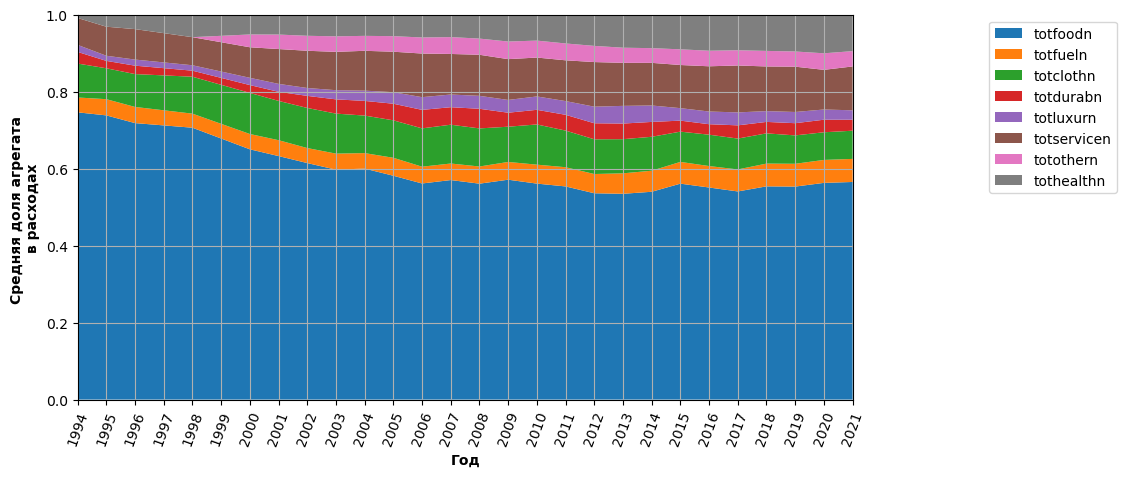

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

ax.stackplot(dfdf.index,dfdf.totfoodn,dfdf.totfueln,dfdf.totclothn, 
             dfdf.totdurabn, dfdf.totluxurn, dfdf.totservicen, dfdf.totothern,
             dfdf.tothealthn,
             alpha=1)


ax.set_title('')
ax.set_xlabel('Год',fontweight='bold')
ax.set_ylabel('Средняя доля агрегата \nв расходах',fontweight='bold')
ax.legend(dfdf.columns,loc='best', bbox_to_anchor=(0.85, 0.5, 0.5, 0.5))
plt.xticks(rotation=70)
ax.set_xticks(range(1994,2022),rotation=135)
plt.xlim(1994,2021)
plt.ylim(0,1)
plt.grid()
plt.show()

## Получение индексов цен/условных количеств

\begin{equation}\label{eq:}
price=\frac{nom cost}{realcost}
\end{equation}


In [16]:
all_constr_cols={
 'totexpn': 'Общий объем расходов домохозяйства: номинальные (в ценах года опроса)',
 'totexpr': 'Общий объем расходов домохозяйства: реальные (в ценах 2003 года)',
 'dairyn': 'Общие расходы домохозяйства на молочные продукты: номинальные (в ценах года опроса)',
 'dairyr': 'Общие расходы домохозяйства на молочные продукты: реальные (в ценах 2003 года)',
 'meatn': 'Общие расходы домохозяйства на мясные продукты: номинальные (в ценах года опроса)',
 'meatr': 'Общие расходы домохозяйства на мясные продукты: реальные (в ценах 2003 года)',
 'fishn': 'Общие расходы домохозяйства на рыбные продукты: номинальные (в ценах года опроса)',
 'fishr': 'Общие расходы домохозяйства на рыбные продукты: реальные (в ценах 2003 года)',
 'potaton': 'Общие расходы домохозяйства на картофель: номинальные (в ценах года опроса)',
 'potator': 'Общие расходы домохозяйства на картофель: реальные (в ценах 2003 года)',
 'eatoutn': 'Общие расходы домохозяйства на обеды вне дома: номинальные (в ценах года опроса)',
 'eatoutr': 'Общие расходы домохозяйства на обеды вне дома: реальные (в ценах 2003 года)',
 'breadn': 'Общие расходы домохозяйства на хлеб: номинальные (в ценах года опроса)',
 'breadr': 'Общие расходы домохозяйства на хлеб: реальные (в ценах 2003 года)',
 'eggsn': 'Общие расходы домохозяйства на яйца: номинальные (в ценах года опроса)',
 'eggsr': 'Общие расходы домохозяйства на яйца: реальные (в ценах 2003 года)',
 'fatn': 'Общие расходы домохозяйства на сало, жиры: номинальные (в ценах года опроса)',
 'fatr': 'Общие расходы домохозяйства на сало, жиры: реальные (в ценах 2003 года)',
 'fruitsn': 'Общие расходы домохозяйства на фрукты: номинальные (в ценах года опроса)',
 'fruitsr': 'Общие расходы домохозяйства на фрукты: реальные (в ценах 2003 года)',
 'sugarn': 'Общие расходы домохозяйства на сахар: номинальные (в ценах года опроса)',
 'sugarr': 'Общие расходы домохозяйства на сахар: реальные (в ценах 2003 года)',
 'vegetn': 'Общие расходы домохозяйства на овощи: номинальные (в ценах года опроса)',
 'vegetr': 'Общие расходы домохозяйства на овощи: реальные (в ценах 2003 года)',
 'ofoodn': 'Общие расходы домохозяйства на прочие продукты: номинальные (в ценах года опроса)',
 'ofoodr': 'Общие расходы домохозяйства на прочие продукты: реальные (в ценах 2003 года)',
 'tobacn': 'Общие расходы домохозяйства на табак: номинальные (в ценах года опроса)',
 'tobacr': 'Общие расходы домохозяйства на табак: реальные (в ценах 2003 года)',
 'alcohln': 'Общие расходы домохозяйства на алкоголь: номинальные (в ценах года опроса)',
 'alcohlr': 'Общие расходы домохозяйства на алкоголь: реальные (в ценах 2003 года)',
 'clothn': 'Общие расходы домохозяйства на одежду: номинальные (в ценах года опроса)',
 'clothr': 'Общие расходы домохозяйства на одежду: реальные (в ценах 2003 года)',
 'fuelaun': 'Общие расходы домохозяйства на топливо: номинальные (в ценах года опроса)',
 'fuelaur': 'Общие расходы домохозяйства на топливо: реальные (в ценах 2003 года)',
 'fuelwdn': 'Общие расходы домохозяйства на древесину: номинальные (в ценах года опроса)',
 'fuelwdr': 'Общие расходы домохозяйства на древесину: реальные (в ценах 2003 года)',
 'fuelgsn': 'Общие расходы домохозяйства на газ: номинальные (в ценах года опроса)',
 'fuelgsr': 'Общие расходы домохозяйства на газ: реальные (в ценах 2003 года)',
 'durabn': 'Общие расходы домохозяйства на товары длительного пользования: номинальные (в ценах года опроса)',
 'durabr': 'Общие расходы домохозяйства на товары длительного пользования: реальные (в ценах 2003 года)',
 'luxurn': 'Общие расходы домохозяйства на товары престижного потребления: номинальные (в ценах года опроса)',
 'luxurr': 'Общие расходы домохозяйства на товары престижного потребления: реальные (в ценах 2003 года)',
 'healthn': 'Общие расходы домохозяйства на медицинские услуги: номинальные (в ценах года опроса)',
 'healthr': 'Общие расходы домохозяйства на медицинские услуги: реальные (в ценах 2003 года)',
 'oservcn': 'ОБЩИЕ РАСХОДЫ HH НА ОБУЧЕНИЕ И ВОСПИТАНИЕ (КРУЖКИ, СЕКЦИИ, КНИГИ), ОТДЫХ И РАЗВЛЕЧЕНИЯ (БИЛЕТЫ, ПУТЕВКИ), РЕМОНТ ДОМА\\ДАЧИ\\АВТО\\ КУЛЬТТОВАРОВ,  И Т.П.: НОМИНАЛЬНЫЕ',
 'oservcr': 'ОБЩИЕ РАСХОДЫ HH НА ОБУЧЕНИЕ И ВОСПИТАНИЕ (КРУЖКИ, СЕКЦИИ, КНИГИ), ОТДЫХ И РАЗВЛЕЧЕНИЯ (БИЛЕТЫ, ПУТЕВКИ), РЕМОНТ ДОМА\\ДАЧИ\\АВТО\\ КУЛЬТТОВАРОВ,  И Т.П.: РЕАЛЬНЫЕ',
 'servicn': 'ОБЩИЕ РАСХОДЫ HH ДОМОХОЗЯЙСТВА НА ВСЕ ВИДЫ УСЛУГ ОБСЛУЖИВАНИЯ (ВКЛЮЧАЯ МЕДИЦИНСКИЕ) РАСХОДЫ НА ЛЕЧЕНИЕ: НОМИНАЛЬНЫЕ',
 'servicr': 'ОБЩИЕ РАСХОДЫ HH ДОМОХОЗЯЙСТВА НА ВСЕ ВИДЫ УСЛУГ ОБСЛУЖИВАНИЯ (ВКЛЮЧАЯ МЕДИЦИНСКИЕ) РАСХОДЫ НА ЛЕЧЕНИЕ:РЕАЛЬНЫЕ',
 'paymntn': 'Общие расходы домохозяйства на алименты, уплату долга, кредита, страховки: номинальные (в ценах года опроса)',
 'paymntr': 'Общие расходы домохозяйства на алименты, уплату долга, кредита, страховки: реальные (в ценах 2003 года)',
 'rentun': 'Общие расходы домохозяйства на оплату квартиры и коммунальных услуг: номинальные (в ценах года опроса)',
 'rentur': 'Общие расходы домохозяйства на оплату квартиры и коммунальных услуг: реальные (в ценах 2003 года)',
 'bondsn': 'Общие расходы домохозяйства на облигации и ценные бумаги: номинальные (в ценах года опроса)',
 'bondsr': 'Общие расходы домохозяйства на облигации и ценные бумаги: реальные (в ценах 2003 года)',
 'assistn': 'Общие расходы домохозяйства на другие нужды: номинальные (в ценах года опроса)',
 'assistr': 'Общие расходы домохозяйства на другие нужды: реальные (в ценах 2003 года)',
 'miscnfn': 'Общие непродуктовые расходы домохозяйства (хоз.товары, косметика и т.п.): номинальные (в ценах года опроса)',
 'miscnfr': 'Общие непродуктовые расходы домохозяйства (хоз.товары, косметика и т.п.): реальные (в ценах 2003 года)',
 'savingn': 'Накопления домохозяйства: номинальные (в ценах года опроса)',
 'savingr': 'Накопления домохозяйства: реальные (в ценах 2003 года)',
 'hprgncn': 'Общий натуральный доход домохозяйства от выращенного, безналичные: номинальные (в ценах года опроса)',
 'hprgncr': 'Общий натуральный доход домохозяйства от выращенного, безналичные: реальные (в ценах 2003 года)',
    
    
}

In [17]:

r_all_constr_cols=[i for i in all_constr_cols.keys() if i[-1]=='r']
n_all_constr_cols=[i for i in all_constr_cols.keys() if i[-1]=='n']

In [18]:
n_all_constr_cols.append('index')
n_constr_df=constr_df[n_all_constr_cols].set_index('index')
n_constr_df=n_constr_df.rename(columns={i:i[:-1] for i in n_all_constr_cols})

In [19]:
r_all_constr_cols.append('index')
r_constr_df=constr_df[r_all_constr_cols].set_index('index')
r_constr_df=r_constr_df.rename(columns={i:i[:-1] for i in r_all_constr_cols})

In [20]:
(n_constr_df/r_constr_df).join(constr_df['id_w']).groupby('id_w').mean()

,totexp,dairy,meat,fish,potato,eatout,bread,eggs,fat,fruits,...,health,oservc,servic,paymnt,rentu,bonds,assist,miscnf,saving,hprgnc
id_w,,,,,,,,,,,,,,,,,,,,,
1994,67.995155,68.324999,68.320247,68.349880,69.137927,68.195918,68.029192,68.636810,68.042749,68.548776,...,68.129650,68.079811,68.069810,67.858135,68.192291,69.459029,68.122984,NaN,68.317362,67.992211
1995,164.626791,164.507374,164.551288,164.387362,163.898025,164.608266,164.605677,164.493546,164.554685,164.433996,...,164.575320,164.581915,164.579493,164.530209,164.562283,165.010303,164.557932,NaN,164.431534,165.639497
1996,209.654596,209.738316,209.748112,209.724289,209.795738,209.758122,209.681846,209.807442,209.739719,209.725627,...,209.690498,209.738539,209.677764,209.637943,209.739594,210.561308,209.715116,NaN,209.652828,209.571534
1998,0.391609,0.391936,0.391906,0.392386,0.392075,0.392613,0.391653,0.392122,0.391652,0.391849,...,0.391833,0.391734,0.391675,0.390769,0.391794,0.387169,0.391893,NaN,0.391067,0.390970
2000,0.700386,0.700553,0.700643,0.700694,0.700547,0.700812,0.700338,0.700661,0.700471,0.700297,...,0.700407,0.700632,0.700425,0.700548,0.700553,0.700848,0.700190,0.700402,0.700207,0.700124
2001,0.835250,0.835581,0.835584,0.835511,0.836972,0.835741,0.835262,0.836063,0.835285,0.836096,...,0.835357,0.835578,0.835399,0.834663,0.835577,0.838275,0.835132,0.835262,0.835648,0.834175
2002,0.959186,0.959472,0.959534,0.959292,0.960183,0.959685,0.959194,0.959626,0.959144,0.959956,...,0.959291,0.959468,0.959265,0.958953,0.959352,0.962821,0.959240,0.959169,0.958650,0.958159
2003,1.087742,1.087875,1.087949,1.088192,1.088743,1.088501,1.087737,1.088258,1.087684,1.088182,...,1.087573,1.087979,1.087821,1.087737,1.087907,1.097591,1.087616,1.087717,1.087577,1.086934
2004,1.212566,1.212857,1.212832,1.213118,1.215059,1.213451,1.212582,1.213509,1.212611,1.213413,...,1.212720,1.212948,1.212686,1.212245,1.212853,NaN,1.212106,1.212583,1.212643,1.211434


In [21]:
tot_columns=[
    'totconsn','totfoodn','totfueln', 'totclothn','totdurabn', 'totluxurn', 'totservicen', 'totothern','tothealthn',
    'totconsr','totfoodr','totfuelr', 'totclothr','totdurabr', 'totluxurr', 'totservicer', 'tototherr','tothealthr'
]

r_tot_cols=[i for i in tot_columns if i[-1]=='r']
n_tot_cols=[i for i in tot_columns if i[-1]=='n']

In [22]:
n_tot_cols.append('index')
n_tot_df=constr_df[n_tot_cols].set_index('index')
n_tot_df=n_tot_df.rename(columns={i:i[:-1] for i in n_tot_cols})

KeyError: "['totconsn', 'totfoodn', 'totfueln', 'totclothn', 'totdurabn', 'totluxurn', 'totservicen', 'totothern', 'tothealthn'] not in index"

In [30]:
r_tot_cols.append('index')
r_tot_df=constr_df[r_tot_cols].set_index('index')
r_tot_df=r_tot_df.rename(columns={i:i[:-1] for i in r_tot_cols})

In [31]:
r_tot_df

,totcons,totfood,totfuel,totcloth,totdurab,totluxur,totservice,totother,tothealth
index,,,,,,,,,
0,19532.900002,8413.249985,0.00,10090.43,605.43,0.0,423.799988,0.00,0.00
1,25454.299995,25058.129822,0.00,0.00,0.00,0.0,393.529999,0.00,0.00
2,2780.080002,1871.410011,0.00,908.14,0.00,0.0,0.000000,0.00,0.00
3,1312.479993,343.800003,0.00,756.78,0.00,0.0,211.899994,0.00,0.00
4,14999.559971,13206.910004,0.00,1261.30,0.00,0.0,529.750000,0.00,0.00
...,...,...,...,...,...,...,...,...,...
151901,18508.770000,9607.140000,450.45,2280.65,4181.18,0.0,975.810000,450.45,563.06
151902,4600.940000,4459.930000,0.00,0.00,0.00,0.0,0.000000,49.89,91.12
151903,6053.580000,3763.390000,0.00,0.00,0.00,0.0,0.000000,58.04,2232.14


In [ ]:
constr_df.reset_index()

In [34]:
constr_df['after2014']=(constr_df.id_w>=2014).astype(int)

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
constr_df

,index,id_w,redid_h,id_h,aid_h,bid_h,cid_h,did_h,eid_h,fid_h,...,totfoodr,totfuelr,totclothr,totdurabr,totluxurr,totservicer,tototherr,tothealthr,after2000,after2014
0,0,1994,1.0,1001.0,1001.0,NaN,NaN,NaN,NaN,NaN,...,8413.249985,0.00,10090.43,605.43,0.0,423.799988,0.00,0.00,0,0
1,1,1994,2.0,1002.0,1002.0,NaN,NaN,NaN,NaN,NaN,...,25058.129822,0.00,0.00,0.00,0.0,393.529999,0.00,0.00,0,0
2,2,1994,3.0,1003.0,1003.0,NaN,NaN,NaN,NaN,NaN,...,1871.410011,0.00,908.14,0.00,0.0,0.000000,0.00,0.00,0,0
3,3,1994,4.0,1004.0,1004.0,NaN,NaN,NaN,NaN,NaN,...,343.800003,0.00,756.78,0.00,0.0,211.899994,0.00,0.00,0,0
4,4,1994,5.0,1005.0,1005.0,NaN,NaN,NaN,NaN,NaN,...,13206.910004,0.00,1261.30,0.00,0.0,529.750000,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151901,151901,2021,992.0,14290014.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9607.140000,450.45,2280.65,4181.18,0.0,975.810000,450.45,563.06,1,1
151902,151902,2021,175.0,14290015.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4459.930000,0.00,0.00,0.00,0.0,0.000000,49.89,91.12,1,1
151903,151903,2021,6762.0,14290016.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3763.390000,0.00,0.00,0.00,0.0,0.000000,58.04,2232.14,1,1
151904,151904,2021,993.0,14290017.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4743.260000,0.00,52.07,0.00,0.0,0.000000,103.60,0.00,1,1


In [92]:
n_tot_df

,totcons,totfood,totfuel,totcloth,totdurab,totluxur,totservice,totother,tothealth
index,,,,,,,,,
0,1290523.79,555857.12,0.0,666666.67,40000.00,0.0,28000.00,0.0,0.0
1,1681571.45,1655571.45,0.0,0.00,0.00,0.0,26000.00,0.0,0.0
2,183642.86,123642.86,0.0,60000.00,0.00,0.0,0.00,0.0,0.0
3,86714.29,22714.29,0.0,50000.00,0.00,0.0,14000.00,0.0,0.0
4,990904.76,872571.43,0.0,83333.33,0.00,0.0,35000.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...
151901,82178.86,42655.72,2000.0,10126.07,18564.46,0.0,4332.61,2000.0,2500.0
151902,20198.10,19579.10,0.0,0.00,0.00,0.0,0.00,219.0,400.0
151903,27120.00,16860.00,0.0,0.00,0.00,0.0,0.00,260.0,10000.0


In [132]:
555857.12/8413.249985

66.06925040751656

In [93]:
r_tot_df

,totcons,totfood,totfuel,totcloth,totdurab,totluxur,totservice,totother,tothealth
index,,,,,,,,,
0,19532.900002,8413.249985,0.00,10090.43,605.43,0.0,423.799988,0.00,0.00
1,25454.299995,25058.129822,0.00,0.00,0.00,0.0,393.529999,0.00,0.00
2,2780.080002,1871.410011,0.00,908.14,0.00,0.0,0.000000,0.00,0.00
3,1312.479993,343.800003,0.00,756.78,0.00,0.0,211.899994,0.00,0.00
4,14999.559971,13206.910004,0.00,1261.30,0.00,0.0,529.750000,0.00,0.00
...,...,...,...,...,...,...,...,...,...
151901,18508.770000,9607.140000,450.45,2280.65,4181.18,0.0,975.810000,450.45,563.06
151902,4600.940000,4459.930000,0.00,0.00,0.00,0.0,0.000000,49.89,91.12
151903,6053.580000,3763.390000,0.00,0.00,0.00,0.0,0.000000,58.04,2232.14


In [133]:
df2000

,totcons,totfood,totfuel,totcloth,totdurab,totluxur,totservice,totother,tothealth
index,,,,,,,,,
15338,0.691212,0.691210,0.691221,0.691207,0.691210,NaN,0.691208,0.691222,0.691389
15339,0.705652,0.705652,NaN,0.705653,NaN,NaN,0.705650,0.705667,0.705650
15340,0.691217,0.691204,NaN,0.691207,NaN,NaN,0.691207,0.691220,NaN
15341,0.716242,0.716240,NaN,NaN,NaN,NaN,0.716240,0.716292,0.716239
15342,0.691211,0.691211,NaN,0.691207,NaN,NaN,0.691214,0.691212,0.691216
...,...,...,...,...,...,...,...,...,...
151901,4.439996,4.440002,4.440004,4.439993,4.440005,NaN,4.440014,4.440004,4.440024
151902,4.389994,4.390002,NaN,NaN,NaN,NaN,NaN,4.389657,4.389816
151903,4.479994,4.480003,NaN,NaN,NaN,NaN,NaN,4.479669,4.480006


In [98]:
df2000=(n_tot_df/r_tot_df).join(constr_df['id_w'])[constr_df.id_w==2000]

In [111]:
df2000=(n_tot_df/r_tot_df).join(constr_df['id_w'])[constr_df.id_w>=2000].iloc[:,:-1]

In [131]:
df2000.join(constr_df['id_w']).groupby('id_w').mean()

,totcons,totfood,totfuel,totcloth,totdurab,totluxur,totservice,totother,tothealth
id_w,,,,,,,,,
2000,0.700198,0.700389,0.700225,0.700481,0.700496,0.700504,0.700632,0.700402,0.700407
2001,NaN,0.835256,0.834647,0.835364,0.835915,0.834387,0.835578,0.835262,0.835357
2002,0.957485,0.959179,0.958448,0.959279,0.959609,0.958614,0.959468,0.959169,0.959291
2003,1.087497,1.087747,1.087120,1.088079,1.088231,1.087633,1.087979,1.087717,1.087573
2004,1.212568,1.212566,1.212462,1.212995,1.213362,1.211956,1.212948,1.212583,1.212720
2005,1.356752,1.356924,1.356531,1.357116,1.357505,1.356365,1.357090,1.356930,1.356892
2006,1.477196,1.482247,1.482049,1.482383,1.482273,1.482147,1.482415,1.482268,1.482450
2007,1.646387,1.646387,1.645907,1.646652,1.647162,1.645088,1.646582,1.646460,1.646593
2008,1.875078,1.875076,1.875080,1.875185,1.875520,1.875362,1.875133,1.875098,1.875176


In [116]:
df2000.totfood

index
15338     0.691210
15339     0.705652
15340     0.691204
15341     0.716240
15342     0.691211
            ...   
151901    4.440002
151902    4.390002
151903    4.480003
151904    4.439984
151905    4.440037
Name: totfood, Length: 127553, dtype: float64

In [125]:
np.array(df2000.totfood).reshape(len(df2000.totfood),1)

array([[0.69120993],
       [0.7056517 ],
       [0.69120353],
       ...,
       [4.4800034 ],
       [4.43998431],
       [4.44003671]])

In [126]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(np.array(df2000.totfood).reshape(len(df2000.totfood),1))

array([[-1.71475068],
       [-1.70168716],
       [-1.71475647],
       ...,
       [ 1.71245917],
       [ 1.67625931],
       [ 1.6763067 ]])

In [23]:
constr_df=constr_df.join(n_tot_df/r_tot_df).rename(columns={i: i+'_price' for i in r_tot_df.columns}).set_index('index')

NameError: name 'n_tot_df' is not defined

In [37]:
regr_dfs={j:constr_df.dropna(subset=[j]) for j in [i+'_price' for i in r_tot_df.columns]}

In [90]:
regr_dfs['totfuel_price'].loc[:,regr_dfs.keys()].join(constr_df['id_w']).groupby('id_w').mean()

,totcons_price,totfood_price,totfuel_price,totcloth_price,totdurab_price,totluxur_price,totservice_price,totother_price,tothealth_price
id_w,,,,,,,,,
2000,0.700226,0.700243,0.700225,0.700354,0.700737,0.699816,0.700445,0.700171,0.700367
2001,0.834648,0.834653,0.834647,0.834982,0.835296,0.834371,0.835088,0.834676,0.834807
2002,0.958448,0.958447,0.958448,0.958726,0.958144,0.957681,0.958771,0.958440,0.958501
2003,1.087118,1.087122,1.087120,1.087419,1.087622,1.087210,1.087500,1.087108,1.086869
2004,1.212462,1.212463,1.212462,1.212946,1.213000,1.212015,1.213088,1.212456,1.212776
2005,1.356529,1.356521,1.356531,1.356759,1.357303,1.356274,1.356855,1.356541,1.356457
2006,1.482048,1.482048,1.482049,1.482357,1.482399,1.482000,1.482257,1.482088,1.482210
2007,1.645908,1.645909,1.645907,1.646228,1.646825,1.644298,1.646273,1.645918,1.646089
2008,1.875071,1.875081,1.875080,1.875159,1.875256,1.875248,1.875177,1.875124,1.875124


<AxesSubplot:xlabel='id_w'>

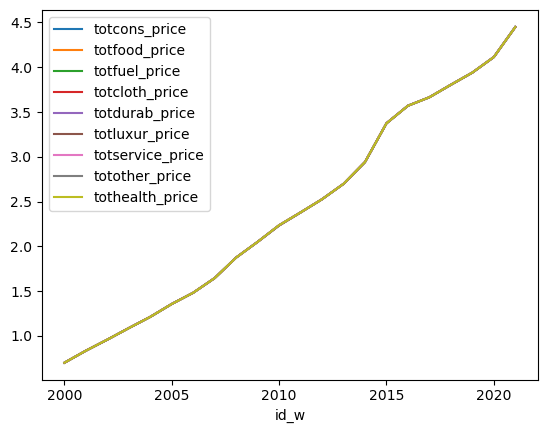

In [89]:
regr_dfs['totfuel_price'].loc[:,regr_dfs.keys()].join(constr_df['id_w']).groupby('id_w').mean().plot()

<AxesSubplot:xlabel='index'>

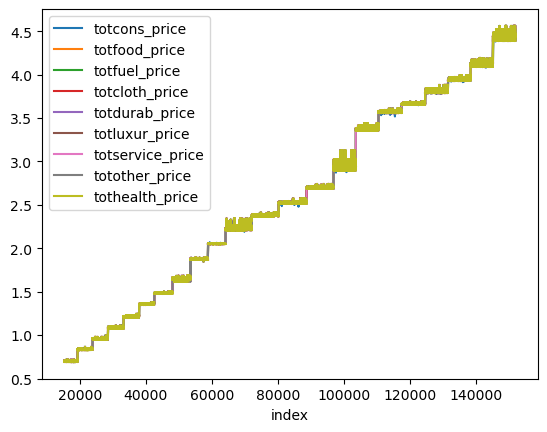

In [80]:
regr_dfs['totfuel_price'].loc[:,regr_dfs.keys()].plot()

In [39]:
for key in regr_dfs.keys():
    regr_dfs[key]=regr_dfs[key][regr_dfs[key].id_w>=2000]
    regr_dfs[key]['after2014']=(regr_dfs[key].id_w>=2014).astype(int)

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
regr_dfs['totfuel_price']

,id_w,redid_h,id_h,aid_h,bid_h,cid_h,did_h,eid_h,fid_h,gid_h,...,after2014,totcons_price,totfood_price,totfuel_price,totcloth_price,totdurab_price,totluxur_price,totservice_price,totother_price,tothealth_price
index,,,,,,,,,,,,,,,,,,,,,
15338,2000,1127.0,10101.0,1001.0,10101.0,10101.0,10101.0,10101.0,NaN,NaN,...,0,0.691212,0.691210,0.691221,0.691207,0.691210,NaN,0.691208,0.691222,0.691389
15343,2000,1131.0,10107.0,NaN,10107.0,10107.0,NaN,10107.0,NaN,NaN,...,0,0.705651,0.705648,0.705652,0.705661,NaN,0.705651,0.705657,0.705638,0.705655
15346,2000,1134.0,10112.0,NaN,NaN,NaN,NaN,10112.0,NaN,NaN,...,0,0.691212,0.691221,0.691215,NaN,NaN,NaN,0.691244,0.691244,0.691244
15348,2000,1136.0,10204.0,1014.0,NaN,10204.0,10204.0,10204.0,NaN,NaN,...,0,0.691211,0.691211,0.691212,0.691194,NaN,0.691214,0.691215,0.691244,NaN
15351,2000,1139.0,10207.0,1017.0,10207.0,10207.0,10207.0,10207.0,NaN,NaN,...,0,0.691212,0.691211,0.691216,0.691210,NaN,NaN,0.691210,0.691217,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151892,2021,988.0,14290004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.390000,4.390000,4.389999,4.389999,4.390001,NaN,4.390001,4.389996,4.390008
151896,2021,989.0,14290008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.439967,4.440003,4.440004,NaN,NaN,NaN,4.439987,4.439906,4.440010
151899,2021,6760.0,14290011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.440002,4.439996,4.440003,4.440008,NaN,NaN,4.439934,4.440004,4.440016


In [42]:
constr_df[constr_df.columns[constr_df.columns.str.contains('price')]]

,totcons_price,totfood_price,totfuel_price,totcloth_price,totdurab_price,totluxur_price,totservice_price,totother_price,tothealth_price
index,,,,,,,,,
0,66.069237,66.069250,NaN,66.069203,66.068745,NaN,66.068902,NaN,NaN
1,66.062373,66.069234,NaN,NaN,NaN,NaN,66.068661,NaN,NaN
2,66.056682,66.069359,NaN,66.069108,NaN,NaN,NaN,NaN,NaN
3,66.069038,66.068324,NaN,66.069399,NaN,NaN,66.068902,NaN,NaN
4,66.062255,66.069310,NaN,66.069397,NaN,NaN,66.068900,NaN,NaN
...,...,...,...,...,...,...,...,...,...
151901,4.439996,4.440002,4.440004,4.439993,4.440005,NaN,4.440014,4.440004,4.440024
151902,4.389994,4.390002,NaN,NaN,NaN,NaN,NaN,4.389657,4.389816
151903,4.479994,4.480003,NaN,NaN,NaN,NaN,NaN,4.479669,4.480006


In [46]:
constr_df_fill=constr_df.copy()

In [48]:
constr_df_fill=constr_df_fill[constr_df_fill.id_w>=2000]

In [49]:
regr_dfs['totfuel_price']

,id_w,redid_h,id_h,aid_h,bid_h,cid_h,did_h,eid_h,fid_h,gid_h,...,after2014,totcons_price,totfood_price,totfuel_price,totcloth_price,totdurab_price,totluxur_price,totservice_price,totother_price,tothealth_price
index,,,,,,,,,,,,,,,,,,,,,
15338,2000,1127.0,10101.0,1001.0,10101.0,10101.0,10101.0,10101.0,NaN,NaN,...,0,0.691212,0.691210,0.691221,0.691207,0.691210,NaN,0.691208,0.691222,0.691389
15343,2000,1131.0,10107.0,NaN,10107.0,10107.0,NaN,10107.0,NaN,NaN,...,0,0.705651,0.705648,0.705652,0.705661,NaN,0.705651,0.705657,0.705638,0.705655
15346,2000,1134.0,10112.0,NaN,NaN,NaN,NaN,10112.0,NaN,NaN,...,0,0.691212,0.691221,0.691215,NaN,NaN,NaN,0.691244,0.691244,0.691244
15348,2000,1136.0,10204.0,1014.0,NaN,10204.0,10204.0,10204.0,NaN,NaN,...,0,0.691211,0.691211,0.691212,0.691194,NaN,0.691214,0.691215,0.691244,NaN
15351,2000,1139.0,10207.0,1017.0,10207.0,10207.0,10207.0,10207.0,NaN,NaN,...,0,0.691212,0.691211,0.691216,0.691210,NaN,NaN,0.691210,0.691217,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151892,2021,988.0,14290004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.390000,4.390000,4.389999,4.389999,4.390001,NaN,4.390001,4.389996,4.390008
151896,2021,989.0,14290008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.439967,4.440003,4.440004,NaN,NaN,NaN,4.439987,4.439906,4.440010
151899,2021,6760.0,14290011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.440002,4.439996,4.440003,4.440008,NaN,NaN,4.439934,4.440004,4.440016


## Импутация пропусков

In [50]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas

In [52]:
for price in list(regr_dfs.keys())[1:]:
    print(price)
    mod = smf.ols(formula=f'{price}~ totcons_price+id_w+C(status)+C(after2014)+region+ncat1+ncat2+ncat3+ncat4+ncat5+ncat6', data=regr_dfs[price])
    res = mod.fit()
    print(res.summary())
    constr_df_fill.loc[constr_df_fill[constr_df.loc[:,price].isnull()].index,
                   price]=res.predict(constr_df)[constr_df[price].isnull()]

totfood_price
                            OLS Regression Results                            
Dep. Variable:          totfood_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.299e+09
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:19:55   Log-Likelihood:             6.7533e+05
No. Observations:              127278   AIC:                        -1.351e+06
Df Residuals:                  127264   BIC:                        -1.350e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


totfuel_price
                            OLS Regression Results                            
Dep. Variable:          totfuel_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.989e+09
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:19:56   Log-Likelihood:             2.7804e+05
No. Observations:               50174   AIC:                        -5.561e+05
Df Residuals:                   50160   BIC:                        -5.559e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


totcloth_price
                            OLS Regression Results                            
Dep. Variable:         totcloth_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.339e+10
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:19:58   Log-Likelihood:             4.8816e+05
No. Observations:               84639   AIC:                        -9.763e+05
Df Residuals:                   84625   BIC:                        -9.762e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


totdurab_price
                            OLS Regression Results                            
Dep. Variable:         totdurab_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.049e+09
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:19:59   Log-Likelihood:             1.7445e+05
No. Observations:               28260   AIC:                        -3.489e+05
Df Residuals:                   28246   BIC:                        -3.488e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


totluxur_price
                            OLS Regression Results                            
Dep. Variable:         totluxur_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.670e+09
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:19:59   Log-Likelihood:             1.0708e+05
No. Observations:               18602   AIC:                        -2.141e+05
Df Residuals:                   18588   BIC:                        -2.140e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


totservice_price
                            OLS Regression Results                            
Dep. Variable:       totservice_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.926e+10
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:20:01   Log-Likelihood:             6.2137e+05
No. Observations:              106621   AIC:                        -1.243e+06
Df Residuals:                  106607   BIC:                        -1.243e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


totother_price
                            OLS Regression Results                            
Dep. Variable:         totother_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.145e+10
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:20:02   Log-Likelihood:             6.4205e+05
No. Observations:              116381   AIC:                        -1.284e+06
Df Residuals:                  116367   BIC:                        -1.284e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


tothealth_price
                            OLS Regression Results                            
Dep. Variable:        tothealth_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.264e+10
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        02:20:04   Log-Likelihood:             5.2942e+05
No. Observations:               93199   AIC:                        -1.059e+06
Df Residuals:                   93185   BIC:                        -1.059e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [53]:
constr_df_fill

,id_w,redid_h,id_h,aid_h,bid_h,cid_h,did_h,eid_h,fid_h,gid_h,...,after2014,totcons_price,totfood_price,totfuel_price,totcloth_price,totdurab_price,totluxur_price,totservice_price,totother_price,tothealth_price
index,,,,,,,,,,,,,,,,,,,,,
15338,2000,1127.0,10101.0,1001.0,10101.0,10101.0,10101.0,10101.0,NaN,NaN,...,0,0.691212,0.691210,0.691221,0.691207,0.691210,0.691179,0.691208,0.691222,0.691389
15339,2000,1128.0,10102.0,1002.0,10102.0,10102.0,10102.0,10102.0,NaN,NaN,...,0,0.705652,0.705652,0.705534,0.705653,0.705605,0.705614,0.705650,0.705667,0.705650
15340,2000,1129.0,10103.0,1003.0,10103.0,10103.0,10103.0,10103.0,NaN,NaN,...,0,0.691217,0.691204,0.691188,0.691207,0.691211,0.691243,0.691207,0.691220,0.691183
15341,2000,3901.0,10104.0,1004.0,10104.0,10104.0,10104.0,10104.0,NaN,NaN,...,0,0.716242,0.716240,0.716169,0.716180,0.716204,0.716242,0.716240,0.716292,0.716239
15342,2000,1130.0,10105.0,1005.0,10105.0,10105.0,10105.0,10105.0,NaN,NaN,...,0,0.691211,0.691211,0.691158,0.691207,0.691182,0.691225,0.691214,0.691212,0.691216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151901,2021,992.0,14290014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.439996,4.440002,4.440004,4.439993,4.440005,4.440150,4.440014,4.440004,4.440024
151902,2021,175.0,14290015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.389994,4.390002,4.390303,4.390213,4.390134,4.390243,4.390184,4.389657,4.389816
151903,2021,6762.0,14290016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.479994,4.480003,4.480204,4.480156,4.480120,4.480170,4.480158,4.479669,4.480006


## Индекс Стоуна

In [55]:
np.log(constr_df_fill[list(regr_dfs.keys())[1:]])

,totfood_price,totfuel_price,totcloth_price,totdurab_price,totluxur_price,totservice_price,totother_price,tothealth_price
index,,,,,,,,
15338,-0.369312,-0.369295,-0.369315,-0.369312,-0.369356,-0.369315,-0.369294,-0.369053
15339,-0.348634,-0.348800,-0.348632,-0.348700,-0.348687,-0.348636,-0.348613,-0.348636
15340,-0.369321,-0.369344,-0.369315,-0.369310,-0.369264,-0.369315,-0.369296,-0.369350
15341,-0.333741,-0.333839,-0.333823,-0.333790,-0.333737,-0.333740,-0.333667,-0.333741
15342,-0.369310,-0.369387,-0.369315,-0.369352,-0.369291,-0.369306,-0.369308,-0.369302
...,...,...,...,...,...,...,...,...
151901,1.490655,1.490655,1.490653,1.490655,1.490688,1.490658,1.490655,1.490660
151902,1.479330,1.479398,1.479378,1.479360,1.479384,1.479371,1.479251,1.479287
151903,1.499624,1.499669,1.499658,1.499650,1.499661,1.499658,1.499549,1.499624


In [57]:
# np.log(constr_df_fill[list(regr_dfs.keys())[1:]])
constr_df_fill=constr_df_fill.join((constr_df_fill.loc[:,['totfoodn','totfueln','totclothn','totdurabn','totluxurn',
                  'totservicen','totothern',
                  'tothealthn']].divide(constr_df_fill.totconsn, axis=0)).rename(columns={i:i[:-1]+'w' for i in ['totfoodn','totfueln','totclothn','totdurabn','totluxurn','totservicen','totothern','tothealthn']}))

In [59]:
constr_df_fill=constr_df_fill.eval('Stone=(totfoodw)*(totfood_price)+totfuelw*totfuel_price+totclothw*totcloth_price+totdurabw*totdurab_price+totluxurw*totluxur_price+totservicew*totservice_price+tototherw*totother_price+tothealthw*tothealth_price')

In [60]:
constr_df_fill=constr_df_fill.eval('resid=log(totconsr)-log(Stone)')

## Получение матрицы для AIDS

In [61]:
aids_matrix=constr_df_fill.loc[:,['id_w','resid',
                                  'totfoodw','totfood_price',
                                  'totfuelw','totfuel_price',
                                  'totclothw', 'totcloth_price',
                                  'totdurabw','totdurab_price',
                                  'totluxurw','totluxur_price',
                                  'totservicew','totservice_price',
                                  'tototherw','totother_price',
                                  'tothealthw','tothealth_price']]

In [62]:
aids_matrix

,id_w,resid,totfoodw,totfood_price,totfuelw,totfuel_price,totclothw,totcloth_price,totdurabw,totdurab_price,totluxurw,totluxur_price,totservicew,totservice_price,tototherw,totother_price,tothealthw,tothealth_price
index,,,,,,,,,,,,,,,,,,
15338,2000,9.054825,0.497776,0.691210,0.034233,0.691221,0.099726,0.691207,0.212749,0.691210,0.0,0.691179,0.117126,0.691208,0.035700,0.691222,0.002690,0.691389
15339,2000,9.174241,0.566922,0.705652,0.000000,0.705534,0.256102,0.705653,0.000000,0.705605,0.0,0.705614,0.124925,0.705650,0.020821,0.705667,0.031231,0.705650
15340,2000,7.598989,0.437246,0.691204,0.000000,0.691188,0.106908,0.691207,0.000000,0.691211,0.0,0.691243,0.385595,0.691207,0.070251,0.691220,0.000000,0.691183
15341,2000,8.488266,0.426415,0.716240,0.000000,0.716169,0.000000,0.716180,0.000000,0.716204,0.0,0.716242,0.368799,0.716240,0.006140,0.716292,0.198646,0.716239
15342,2000,10.158684,0.876368,0.691211,0.000000,0.691158,0.041335,0.691207,0.000000,0.691182,0.0,0.691225,0.025540,0.691214,0.024324,0.691212,0.032432,0.691216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151901,2021,8.335345,0.519060,4.440002,0.024337,4.440004,0.123220,4.439993,0.225903,4.440005,0.0,4.440150,0.052722,4.440014,0.024337,4.440004,0.030421,4.440024
151902,2021,6.954688,0.969354,4.390002,0.000000,4.390303,0.000000,4.390213,0.000000,4.390134,0.0,4.390243,0.000000,4.390184,0.010843,4.389657,0.019804,4.389816
151903,2021,7.208782,0.621681,4.480003,0.000000,4.480204,0.000000,4.480156,0.000000,4.480120,0.0,4.480170,0.000000,4.480158,0.009587,4.479669,0.368732,4.480006


In [ ]:
def AIDS_matrix(df, price_index='Stone'):
    aids_shares=food_agregates(df=df, var='shares')
    aids_costs=food_agregates(df=df,var='costs')
    aids_prices=log(food_agregates(df=df,var='prices'))
    aids_prices.rename(columns={i:'Цена на '+i for i in aids_prices.columns}, inplace=True)

    if price_index=='Stone':
        price_index=stone_price_index(df)
    elif price_index=='Laspeyres':
        price_index=laspeyres_price_index(df)
    elif price_index=='norm Stone':
        price_index=norm_stone_price_index(df)
    
    aids_resid=pd.DataFrame(log(food_agregates(df,'costs',including=['total']).iloc[:,-1]) - price_index, columns=['Остаток'])
    
    result_df=aids_shares.join(aids_prices).join(aids_resid)
    result_df=add_constant(result_df)
    return result_df

In [ ]:
['id_w','resid',
                                  'totfoodw','totfood_price',
                                  'totfuelw','totfuel_price',
                                  'totclothw', 'totcloth_price',
                                  'totdurabw','totdurab_price',
                                  'totluxurw','totluxur_price',
                                  'totservicew','totservice_price',
                                  'tototherw','totother_price',
                                  'tothealthw','tothealth_price']

In [63]:
from collections import OrderedDict
from statsmodels.api import add_constant

In [64]:
aids_matrix=add_constant(aids_matrix)

In [67]:
aids_matrix=aids_matrix.dropna()

In [68]:
equations = OrderedDict()
# year,fitted=True,cov_type_1='robust',
#               price_index='Stone',constrained=False,
#               out=False,n_neighbors=30,contamination='auto',homo=True, sym=True)

#     Уравнения должны генерироваться  автоматически, не смотря на стиль агрегации
    #1
equations['totfoodw'] = {'dependent': aids_matrix['totfoodw'],
                         'exog': aids_matrix[[ 'const','totfood_price', 'totfuel_price', 'totcloth_price','totdurab_price', 'totservice_price', 'totother_price','tothealth_price','totluxur_price','resid']]}
#2
equations['totfuelw'] = {'dependent': aids_matrix['totfuelw'],
                         'exog': aids_matrix[[ 'const','totfood_price', 'totfuel_price', 'totcloth_price','totdurab_price', 'totservice_price', 'totother_price', 'tothealth_price','totluxur_price','resid']]}
#3
equations['totclothw'] = {'dependent': aids_matrix['totclothw'],
                         'exog': aids_matrix[[ 'const','totfood_price', 'totfuel_price', 'totcloth_price','totdurab_price', 'totservice_price', 'totother_price','tothealth_price','totluxur_price',  'resid']]}
#4
equations['totdurabw'] = {'dependent': aids_matrix['totdurabw'],
                         'exog': aids_matrix[[ 'const','totfood_price', 'totfuel_price', 'totcloth_price','totdurab_price', 'totservice_price', 'totother_price','tothealth_price','totluxur_price', 'resid']]}
#5
equations['totservicew'] = {'dependent': aids_matrix['totservicew'],
                         'exog': aids_matrix[[ 'const','totfood_price', 'totfuel_price', 'totcloth_price','totdurab_price', 'totservice_price', 'totother_price','tothealth_price','totluxur_price',  'resid']]}
#6
equations['tototherw'] = {'dependent': aids_matrix['tototherw'],
                       'exog': aids_matrix[[ 'const','totfood_price', 'totfuel_price', 'totcloth_price','totdurab_price', 'totservice_price', 'totother_price','tothealth_price','totluxur_price',  'resid']]}

equations['tothealthw'] = {'dependent': aids_matrix['tothealthw'],
                       'exog': aids_matrix[[ 'const','totfood_price', 'totfuel_price', 'totcloth_price','totdurab_price', 'totservice_price', 'totother_price','tothealth_price','totluxur_price',  'resid']]}

In [69]:
from linearmodels.system import SUR

In [70]:
mod=SUR(equations)

ValueError: Equation totfoodw regressor array is not full rank

In [ ]:
equations['totfoodw']['dependent']

In [ ]:
equations['totfoodw']['exog']

In [ ]:
from numpy.linalg import matrix_rank

In [ ]:
matrix_rank

In [ ]:
(constr_df.loc[:,['totfoodn','totfueln','totclothn','totdurabn','totluxurn','totservicen','totothern','tothealthn']].divide(constr_df.totconsn, axis=0))


In [ ]:
constr_df_fill['Stown']=np.log(constr_df_fill[list(regr_dfs.keys())[1:]]).sum(axis=1)

In [ ]:
regr_dfs.keys()

In [ ]:
['totconsr', S 'totcons_price', 'totfood_price', 'totfuel_price', 'totcloth_price', 'totdurab_price', 'totluxur_price', 'totservice_price', 'totother_price', 'tothealth_price']

In [ ]:
(np.log(constr_df_fill.totconsr)-constr_df_fill.Stown).plot()

In [ ]:
constr_df_fill.Stown.plot()

In [ ]:
constr_df.loc[:,['totother_price','after2000']][constr_df.after2000==0]

In [ ]:
constr_df_fill.loc[constr_df_fill[constr_df.loc[:,'totfood_price'].isnull()].index,
                   'totfood_price']=res.predict(constr_df)[constr_df['totfood_price'].isnull()]

In [ ]:
constr_df_fill[constr_df.loc[:,'totfood_price'].isnull()]['totfood_price']

In [ ]:
res.predict(constr_df)[constr_df['totfood_price'].isnull()]

In [ ]:
'id_w': 'RLMS-HSE: ВОЛНА',
'status': 'Тип населенного пункта',
 'popul': 'Численность населения',
 'region': 'КОД РЕГИОНА',
 'site': 'НОМЕР НАСЕЛЕННОГО ПУНКТА',
 'ncat1': 'Детей <7 лет в домохозяйстве DEMCAT = 1',
 'ncat2': 'Детей 7-18 лет в домохозяйстве DEMCAT = 2',
 'ncat3': 'Мужчины трудоспособного возраста в домохозяйстве: DEMCAT = 3',
 'ncat4': 'Женщины трудоспособного возраста в домохозяйстве: DEMCAT = 4',
 'ncat5': 'Мужчины пенсионного возраста в домохозяйстве: DEMCAT = 5',
 'ncat6': 'Женщины пенсионного возраста в домохозяйстве: DEMCAT = 6',
 'mh': 'Домохозяйство во главе с мужчиной трудоспособного возраста: DEMCAT = 3 (1 = Y 0 = N)',
 'fh': 'Домохозяйство во главе с женщиной трудоспособного возраста: DEMCAT = 4 (1 = Y 0 = N)',
 'rmh': 'Домохозяйство во главе с мужчиной пенсионного возраста: DEMCAT = 5 (1 = Y 0 = N)',
 'rfh': 'Домохозяйство во главе с женщиной пенсионного возраста: DEMCAT = 6 (1 = Y 0 = N)',
 'yh': 'Домохозяйство во главе с молодым человеком до 18 лет:  DEMCAT = 1,2 (1 = Y 0 = N)',
 'hhtype': 'Глава домохозяйства типа (1-5): MH FH RMH RFH YH',
'a.pind': 'HH ВСЕ РОССИИ БЕДНОСТИ IND (1 = НИЖЕ, 0 = НЕТ)',
 'a.pgrp': 'HH ВСЕ ГРУППЫ БЕДНОСТИ ПО РОССИИ (1-5)',
 'a.pthrn': 'Пороговые значения бедности по РОССИИ: номинальное',
 'r.pind': 'HH региональной бедности IND (1 = НИЖЕ, 0 = НЕТ)',
 'r.pgrp': 'HH РЕГИОНАЛЬНАЯ ГРУППА БЕДНОСТИ (1-5)',
 'r.pthrn': 'HH РЕГИОНАЛЬНЫЕ пороговые значения бедности: номинальное',
 'own.bwtv': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ЧЕРНО-БЕЛЫЙ TV',
 'own.c.tv': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ЦВЕТНОЙ TV',
 'own.vcr': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ВИДЕОМАГНИТОФОН',
 'own.auto': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: АВТОМОБИЛЬ',
 'own.frig': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ХОЛОДИЛЬНИК',
 'own.frignf': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ХОЛОДИЛЬНИК - NO FROST',
 'own.wash': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: СТИРАЛЬНАЯ МАШИНА',
 'own.washau': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: СТИРАЛЬНАЯ МАШИНА АВТОМАТ',
 'owndacha': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ДАЧА',
 'own.comp': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: КОМПЬЮТЕР',
 'own.dvdp': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: DVD - ПРОИГРЫВАТЕЛЬ (PLAYER/RECORDER)',
 'own.micr': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: МИКРОВОЛНОВАЯ ПЕЧЬ',
 'sett.typ': 'ТИП ПОСЕЛЕНИЯ'
'totcons'
'after2000'

In [ ]:
((n_tot_df/r_tot_df).join(constr_df['id_w'])[(n_tot_df/r_tot_df).join(constr_df['id_w']).id_w==2001])


## Импутация пропущенных цен с помощью дамми-регрессии

In [ ]:
{'id_w': 'RLMS-HSE: ВОЛНА',
'status': 'Тип населенного пункта',
 'popul': 'Численность населения',
 'region': 'КОД РЕГИОНА',
 'site': 'НОМЕР НАСЕЛЕННОГО ПУНКТА',
 'ncat1': 'Детей <7 лет в домохозяйстве DEMCAT = 1',
 'ncat2': 'Детей 7-18 лет в домохозяйстве DEMCAT = 2',
 'ncat3': 'Мужчины трудоспособного возраста в домохозяйстве: DEMCAT = 3',
 'ncat4': 'Женщины трудоспособного возраста в домохозяйстве: DEMCAT = 4',
 'ncat5': 'Мужчины пенсионного возраста в домохозяйстве: DEMCAT = 5',
 'ncat6': 'Женщины пенсионного возраста в домохозяйстве: DEMCAT = 6',
 'mh': 'Домохозяйство во главе с мужчиной трудоспособного возраста: DEMCAT = 3 (1 = Y 0 = N)',
 'fh': 'Домохозяйство во главе с женщиной трудоспособного возраста: DEMCAT = 4 (1 = Y 0 = N)',
 'rmh': 'Домохозяйство во главе с мужчиной пенсионного возраста: DEMCAT = 5 (1 = Y 0 = N)',
 'rfh': 'Домохозяйство во главе с женщиной пенсионного возраста: DEMCAT = 6 (1 = Y 0 = N)',
 'yh': 'Домохозяйство во главе с молодым человеком до 18 лет:  DEMCAT = 1,2 (1 = Y 0 = N)',
 'hhtype': 'Глава домохозяйства типа (1-5): MH FH RMH RFH YH',
'a.pind': 'HH ВСЕ РОССИИ БЕДНОСТИ IND (1 = НИЖЕ, 0 = НЕТ)',
 'a.pgrp': 'HH ВСЕ ГРУППЫ БЕДНОСТИ ПО РОССИИ (1-5)',
 'a.pthrn': 'Пороговые значения бедности по РОССИИ: номинальное',
 'r.pind': 'HH региональной бедности IND (1 = НИЖЕ, 0 = НЕТ)',
 'r.pgrp': 'HH РЕГИОНАЛЬНАЯ ГРУППА БЕДНОСТИ (1-5)',
 'r.pthrn': 'HH РЕГИОНАЛЬНЫЕ пороговые значения бедности: номинальное',
 'own.bwtv': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ЧЕРНО-БЕЛЫЙ TV',
 'own.c.tv': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ЦВЕТНОЙ TV',
 'own.vcr': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ВИДЕОМАГНИТОФОН',
 'own.auto': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: АВТОМОБИЛЬ',
 'own.frig': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ХОЛОДИЛЬНИК',
 'own.frignf': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ХОЛОДИЛЬНИК - NO FROST',
 'own.wash': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: СТИРАЛЬНАЯ МАШИНА',
 'own.washau': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: СТИРАЛЬНАЯ МАШИНА АВТОМАТ',
 'owndacha': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: ДАЧА',
 'own.comp': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: КОМПЬЮТЕР',
 'own.dvdp': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: DVD - ПРОИГРЫВАТЕЛЬ (PLAYER/RECORDER)',
 'own.micr': 'ДОМОХОЗЯЙСТВО ИМЕЕТ: МИКРОВОЛНОВАЯ ПЕЧЬ',
 'sett.typ': 'ТИП ПОСЕЛЕНИЯ'
'totcons'
'after2000'}

In [ ]:
(n_tot_df/r_tot_df)

In [ ]:
constr_df.merge((n_tot_df/r_tot_df))

In [ ]:
dfdf=(n_tot_df/r_tot_df).join(constr_df['id_w']).groupby('id_w').mean().plot()

### Получение AIDS-оценок

### Получение эластичностей

# 

In [24]:
import pandas as pd

In [25]:
CPI_df=pd.read_excel('cpis.xlsx')

In [26]:
CPI_df.columns=['year', 'CPI', 'CPI_food', 'CPI_nonfood', 'CPI_service', 'BCPI', 'food', 'alcohol']

In [27]:
(CPI_df.iloc[:,1:]/100).join(CPI_df['year'])[CPI_df['year']>=2000]

,CPI,CPI_food,CPI_nonfood,CPI_service,BCPI,food,alcohol,year
9,1.2018,1.1789,1.1849,1.3370,NaN,1.171,1.250,2000
10,1.1858,1.1714,1.1273,1.3690,NaN,1.178,1.126,2001
11,1.1506,1.1099,1.1085,1.3617,NaN,1.113,1.089,2002
12,1.1199,1.1018,1.0919,1.2226,NaN,1.102,1.099,2003
13,1.1173,1.1229,1.0737,1.1774,NaN,1.130,1.087,2004
14,1.1092,1.0957,1.0641,1.2100,NaN,1.099,1.076,2005
15,1.0900,1.0867,1.0601,1.1386,NaN,1.084,1.101,2006
16,1.1187,1.1556,1.0654,1.1333,NaN,1.171,1.077,2007
17,1.1328,1.1645,1.0796,1.1593,NaN,1.176,1.109,2008
18,1.0880,1.0608,1.0965,1.1160,NaN,1.055,1.089,2009


In [154]:
constr_df

,id_w,redid_h,id_h,aid_h,bid_h,cid_h,did_h,eid_h,fid_h,gid_h,...,after2014,totcons_price,totfood_price,totfuel_price,totcloth_price,totdurab_price,totluxur_price,totservice_price,totother_price,tothealth_price
index,,,,,,,,,,,,,,,,,,,,,
0,1994,1.0,1001.0,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,66.069237,66.069250,NaN,66.069203,66.068745,NaN,66.068902,NaN,NaN
1,1994,2.0,1002.0,1002.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,66.062373,66.069234,NaN,NaN,NaN,NaN,66.068661,NaN,NaN
2,1994,3.0,1003.0,1003.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,66.056682,66.069359,NaN,66.069108,NaN,NaN,NaN,NaN,NaN
3,1994,4.0,1004.0,1004.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,66.069038,66.068324,NaN,66.069399,NaN,NaN,66.068902,NaN,NaN
4,1994,5.0,1005.0,1005.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,66.062255,66.069310,NaN,66.069397,NaN,NaN,66.068900,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151901,2021,992.0,14290014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.439996,4.440002,4.440004,4.439993,4.440005,NaN,4.440014,4.440004,4.440024
151902,2021,175.0,14290015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.389994,4.390002,NaN,NaN,NaN,NaN,NaN,4.389657,4.389816
151903,2021,6762.0,14290016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4.479994,4.480003,NaN,NaN,NaN,NaN,NaN,4.479669,4.480006


Обнаруженные повторы:
1. ``servicn``
2. ``assistn``

Формула, которая приравнивает к нулю сумму расходов успешно найдена. 
Теперь необходимо получить агрегаты для оценки AIDS-модели. 

**Агрегаты потребления:**
1. Продукты питания: 
2. Одежда
3. Топливо
4. Товары длительного потребления
5. Товары роскоши
6. ``oservcn`` - различные услуги (образование, развлечения, ремонт и т.д.)
7. ``miscnfn`` - прочие товары

**Обязательные расходы (не входят в потребительские расходы):**
1. ``paymntn`` - Общие расходы домохозяйства на алименты, уплату долга, кредита, страховки
2. ``rentun`` - 'Общие расходы домохозяйства на оплату квартиры и коммунальных услуг
3. ``bondsn`` - Общие расходы домохозяйства на облигации и ценные бумаги
4. ``hprgncn`` - Общий натуральный доход домохозяйства от выращенного, безналичные
5. ``savingn`` - Накопления домохозяйства

In [10]:
t='n'
constr_df[f'totcons{t}']=constr_df.fillna(0).eval(f'totexp{t}-paymnt{t}-rentu{t}-bonds{t}-hprgnc{t}-saving{t}')
constr_df[f'totfood{t}']=constr_df.fillna(0).eval(f'dairy{t}+meat{t}+fish{t}+potato{t}+eatout{t}+bread{t}+eggs{t}+fat{t}+fruits{t}+sugar{t}+veget{t}+ofood{t}+tobac{t}+alcohl{t}')
constr_df[f'totfuel{t}']=constr_df.fillna(0).eval(f'fuelau{t}+fuelwd{t}+fuelgs{t}')
constr_df[f'totcloth{t}']=constr_df.fillna(0).eval(f'cloth{t}')
constr_df[f'totdurab{t}']=constr_df.fillna(0).eval(f'durab{t}')
constr_df[f'totluxur{t}']=constr_df.fillna(0).eval(f'luxur{t}')
constr_df[f'totservice{t}']=constr_df.fillna(0).eval(f'oservc{t}')
constr_df[f'totother{t}']=constr_df.fillna(0).eval(f'miscnf{t}')
constr_df[f'tothealth{t}']=constr_df.fillna(0).eval(f'health{t}')

In [28]:
t='n'
constr_df=constr_df.fillna(0).eval(f'FOOD{t} = dairy{t}+meat{t}+fish{t}+potato{t}+eatout{t}+bread{t}+eggs{t}+fat{t}+fruits{t}+sugar{t}+veget{t}+ofood{t}+tobac{t}+alcohl{t}')
constr_df=constr_df.fillna(0).eval(f'NONFOOD{t} = fuelau{t}+fuelwd{t}+fuelgs{t} + cloth{t} + durab{t} + luxur{t} + miscnf{t}')
constr_df=constr_df.fillna(0).eval(f'SERVICE{t} = oservc{t} + health{t}')
constr_df=constr_df.fillna(0).eval(f'CONSUMPTION{t} = FOOD{t} + NONFOOD{t} + SERVICE{t}')

In [29]:
t='r'
constr_df=constr_df.fillna(0).eval(f'FOOD{t} = dairy{t}+meat{t}+fish{t}+potato{t}+eatout{t}+bread{t}+eggs{t}+fat{t}+fruits{t}+sugar{t}+veget{t}+ofood{t}+tobac{t}+alcohl{t}')
constr_df=constr_df.fillna(0).eval(f'NONFOOD{t} = fuelau{t}+fuelwd{t}+fuelgs{t} + cloth{t} + durab{t} + luxur{t} + miscnf{t}')
constr_df=constr_df.fillna(0).eval(f'SERVICE{t} = oservc{t} + health{t}')
constr_df=constr_df.fillna(0).eval(f'CONSUMPTION{t} = FOOD{t} + NONFOOD{t} + SERVICE{t}')

In [30]:
constr_df.loc[:,['id_w','SERVICEn', 'NONFOODn', 'FOODn', 'CONSUMPTIONn']][constr_df.id_w>=2000]

,id_w,SERVICEn,NONFOODn,FOODn,CONSUMPTIONn
15338,2000,490.00,1563.90,2035.71,4089.61
15339,2000,750.00,1330.03,2722.87,4802.90
15340,2000,367.75,168.96,417.01,953.72
15341,2000,1414.00,15.30,1062.57,2491.87
15342,2000,715.00,809.80,10808.58,12333.38
...,...,...,...,...,...
151901,2021,6832.61,32690.53,42655.72,82178.86
151902,2021,400.00,219.00,19579.10,20198.10
151903,2021,10000.00,260.00,16860.00,27120.00
151904,2021,0.00,691.21,21060.00,21751.21


In [31]:
constr_df.loc[:,['SERVICEn', 'NONFOODn', 'FOODn']].divide(constr_df['CONSUMPTIONn'], axis=0)[constr_df.id_w>=2000].join(constr_df['id_w']).groupby('id_w').mean().rename(columns={'SERVICEn':'SERVICEw', 'NONFOODn':'NONFOODw', 'FOODn':'FOODw'})

,SERVICEw,NONFOODw,FOODw
id_w,,,
2000,0.130727,0.219040,0.650233
2001,0.141985,0.225214,0.632800
2002,0.150815,0.234144,0.615041
2003,0.155885,0.246820,0.597295
2004,0.158739,0.241272,0.599990
2005,0.160775,0.257566,0.581660
2006,0.170311,0.266737,0.562952
2007,0.163847,0.265982,0.570171
2008,0.169028,0.270174,0.560798


In [32]:
dfdf

NameError: name 'dfdf' is not defined

In [33]:
fig, ax = plt.subplots(figsize=(10,5))

ax.stackplot(dfdf.index,dfdf.SERVICEn,dfdf.NONFOODn,dfdf.FOODn, 
             alpha=1)


ax.set_title('')
ax.set_xlabel('Год',fontweight='bold')
ax.set_ylabel('Средняя доля агрегата \nв расходах',fontweight='bold')
ax.legend(dfdf.columns,loc='best', bbox_to_anchor=(0.85, 0.5, 0.5, 0.5))
plt.xticks(rotation=70)
ax.set_xticks(range(1994,2022),rotation=135)
plt.xlim(2000,2021)
plt.ylim(0,1)
plt.grid()
plt.show()

NameError: name 'plt' is not defined

In [11]:
t='r'
constr_df[f'totcons{t}']=constr_df.fillna(0).eval(f'totexp{t}-paymnt{t}-rentu{t}-bonds{t}-hprgnc{t}-saving{t}')
constr_df[f'totfood{t}']=constr_df.fillna(0).eval(f'dairy{t}+meat{t}+fish{t}+potato{t}+eatout{t}+bread{t}+eggs{t}+fat{t}+fruits{t}+sugar{t}+veget{t}+ofood{t}+tobac{t}+alcohl{t}')
constr_df[f'totfuel{t}']=constr_df.fillna(0).eval(f'fuelau{t}+fuelwd{t}+fuelgs{t}')
constr_df[f'totcloth{t}']=constr_df.fillna(0).eval(f'cloth{t}')
constr_df[f'totdurab{t}']=constr_df.fillna(0).eval(f'durab{t}')
constr_df[f'totluxur{t}']=constr_df.fillna(0).eval(f'luxur{t}')
constr_df[f'totservice{t}']=constr_df.fillna(0).eval(f'oservc{t}')
constr_df[f'totother{t}']=constr_df.fillna(0).eval(f'miscnf{t}')
constr_df[f'tothealth{t}']=constr_df.fillna(0).eval(f'health{t}')

In [12]:
constr_df=constr_df[constr_df.totconsn!=0]

In [206]:
(CPI_df.iloc[:,1:]/100).join(CPI_df['year'])[CPI_df['year']>=2000]

,CPI,CPI_food,CPI_nonfood,CPI_service,BCPI,food,alcohol,year
9,1.20,1.18,1.18,1.34,NaN,1.17,1.25,2000
10,1.19,1.17,1.13,1.37,NaN,1.18,1.13,2001
11,1.15,1.11,1.11,1.36,NaN,1.11,1.09,2002
12,1.12,1.10,1.09,1.22,NaN,1.10,1.10,2003
13,1.12,1.12,1.07,1.18,NaN,1.13,1.09,2004
14,1.11,1.10,1.06,1.21,NaN,1.10,1.08,2005
15,1.09,1.09,1.06,1.14,NaN,1.08,1.10,2006
16,1.12,1.16,1.07,1.13,NaN,1.17,1.08,2007
17,1.13,1.16,1.08,1.16,NaN,1.18,1.11,2008
18,1.09,1.06,1.10,1.12,NaN,1.05,1.09,2009


<AxesSubplot:>

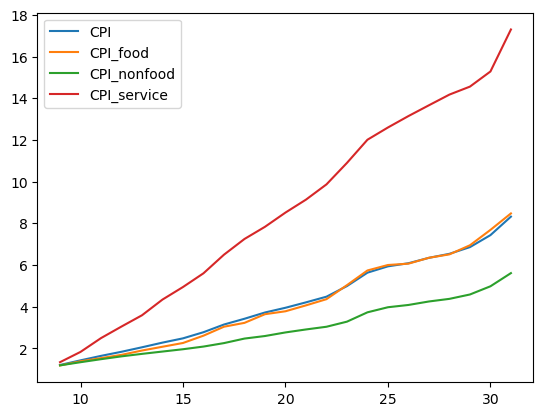

In [34]:
(CPI_df.iloc[:,1:]/100).join(CPI_df['year'])[CPI_df['year']>=2000].loc[:,['CPI', 'CPI_food', 'CPI_nonfood', 'CPI_service']].cumprod().plot()

In [82]:
cpi_aids=(CPI_df.iloc[:,1:]/100).join(CPI_df['year'])[CPI_df['year']<2022][CPI_df['year']>=2000].loc[:,['CPI', 'CPI_food', 'CPI_nonfood', 'CPI_service']].cumprod().join(CPI_df['year']).rename(columns={'year':'id_w'}).set_index('id_w')

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [85]:
cpi_aids=(CPI_df.iloc[:,1:]/100).join(CPI_df['year'])[CPI_df['year']<2022][CPI_df['year']>=2000].loc[:,['CPI', 'CPI_food', 'CPI_nonfood', 'CPI_service']].join(CPI_df['year']).rename(columns={'year':'id_w'}).set_index('id_w')

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [86]:
cpi_aids.iloc[:,1:]

,CPI_food,CPI_nonfood,CPI_service
id_w,,,
2000,1.1789,1.1849,1.3370
2001,1.1714,1.1273,1.3690
2002,1.1099,1.1085,1.3617
2003,1.1018,1.0919,1.2226
2004,1.1229,1.0737,1.1774
2005,1.0957,1.0641,1.2100
2006,1.0867,1.0601,1.1386
2007,1.1556,1.0654,1.1333
2008,1.1645,1.0796,1.1593


In [237]:
w_aids

,SERVICEw,NONFOODw,FOODw
id_w,,,
2000,0.13,0.22,0.65
2001,0.14,0.23,0.63
2002,0.15,0.23,0.62
2003,0.16,0.25,0.60
2004,0.16,0.24,0.60
2005,0.16,0.26,0.58
2006,0.17,0.27,0.56
2007,0.16,0.27,0.57
2008,0.17,0.27,0.56


In [87]:
w_aids.rename(columns={i:i[:-1].lower() for i in w_aids.columns})

,service,nonfood,food
id_w,,,
2000,0.130727,0.219040,0.650233
2001,0.141985,0.225214,0.632800
2002,0.150815,0.234144,0.615041
2003,0.155885,0.246820,0.597295
2004,0.158739,0.241272,0.599990
2005,0.160775,0.257566,0.581660
2006,0.170311,0.266737,0.562952
2007,0.163847,0.265982,0.570171
2008,0.169028,0.270174,0.560798


In [ ]:
cpi_aids.iloc[:,1:]

In [90]:
(cpi_aids.iloc[:,1:].rename(columns={i:i[4:].lower() for i in cpi_aids.columns})*w_aids.rename(columns={i:i[:-1].lower() for i in w_aids.columns})).sum(axis=1)

id_w
2000    1.200882
2001    1.189524
2002    1.147547
2003    1.118187
2004    1.119681
2005    1.105937
2006    1.088444
2007    1.127955
2008    1.140683
2009    1.079544
2010    1.099284
2011    1.054854
2012    1.068214
2013    1.066910
2014    1.125085
2015    1.131482
2016    1.051061
2017    1.021850
2018    1.043765
2019    1.029162
2020    1.054339
2021    1.089811
dtype: float64

0.17420000000000002

In [63]:
w_aids=constr_df.loc[:,['SERVICEn', 'NONFOODn', 'FOODn']].divide(constr_df['CONSUMPTIONn'], axis=0)[constr_df.id_w>=2000].join(constr_df['id_w']).groupby('id_w').mean().rename(columns={'SERVICEn':'SERVICEw', 'NONFOODn':'NONFOODw', 'FOODn':'FOODw'})

In [64]:
cons_s=constr_df.loc[:,['id_w','CONSUMPTIONn']][constr_df.id_w>=2000].groupby('id_w').mean()

In [65]:
cpi_s=(CPI_df[CPI_df.year>=2000][CPI_df.year<2022].rename(columns={'year':'id_w'}).set_index('id_w').CPI/100)

C:\Users\79618\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [66]:
stone_s=(cpi_aids.iloc[:,1:].rename(columns={i:i[4:].lower() for i in cpi_aids.columns})*w_aids.rename(columns={i:i[:-1].lower() for i in w_aids.columns})).sum(axis=1)

,CPI,CPI_food,CPI_nonfood,CPI_service
id_w,,,,
2000,1.201800,1.178900,1.184900,1.337000
2001,1.425094,1.380963,1.335738,1.830353
2002,1.639714,1.532731,1.480665,2.492392
2003,1.836315,1.688763,1.616738,3.047198
2004,2.051715,1.896312,1.735892,3.587771
2005,2.275762,2.077790,1.847163,4.341203
2006,2.480581,2.257934,1.958177,4.942894
2007,2.775026,2.609268,2.086242,5.601781
2008,3.143549,3.038493,2.252307,6.494145


In [81]:
((cpi_aids.iloc[:,1:].rename(columns={i:i[4:].lower() for i in cpi_aids.columns}))*w_aids.rename(columns={i:i[:-1].lower() for i in w_aids.columns})).sum(axis=1)

id_w
2000    1.200882
2001    1.434585
2002    1.665272
2003    1.882746
2004    2.126108
2005    2.382288
2006    2.635257
2007    2.960467
2008    3.410187
2009    3.740815
2010    4.062458
2011    4.366615
2012    4.754116
2013    5.094698
2014    5.733926
2015    6.530288
2016    6.911457
2017    7.096906
2018    7.390318
2019    7.648630
2020    7.943396
2021    8.658514
dtype: float64

In [279]:
cpi_s.cumprod()

id_w
2000   1.20
2001   1.43
2002   1.64
2003   1.84
2004   2.05
2005   2.28
2006   2.48
2007   2.78
2008   3.14
2009   3.42
2010   3.72
2011   3.95
2012   4.21
2013   4.48
2014   4.99
2015   5.63
2016   5.93
2017   6.08
2018   6.34
2019   6.54
2020   6.86
2021   7.43
Name: CPI, dtype: float64

In [286]:
['CONSUMPTIONn']

id_w
2000   1.20
2001   1.43
2002   1.67
2003   1.88
2004   2.13
2005   2.38
2006   2.64
2007   2.96
2008   3.41
2009   3.74
2010   4.06
2011   4.37
2012   4.75
2013   5.09
2014   5.73
2015   6.53
2016   6.91
2017   7.10
2018   7.39
2019   7.65
2020   7.94
2021   8.66
dtype: float64

In [41]:
cons_s.join(cpi_s).eval()

,CONSUMPTIONn,CPI
id_w,,
2000,3795.216792,1.2018
2001,4910.330508,1.1858
2002,5913.424688,1.1506
2003,7590.967355,1.1199
2004,8651.507519,1.1173
2005,9655.093650,1.1092
2006,13079.293781,1.0900
2007,14932.474677,1.1187
2008,18646.244453,1.1328


In [48]:
real_cons_s=cons_s.join(cpi_s.sort_index(ascending=False).cumprod()).eval('CONSUMPTIONn*CPI')

<AxesSubplot:xlabel='id_w'>

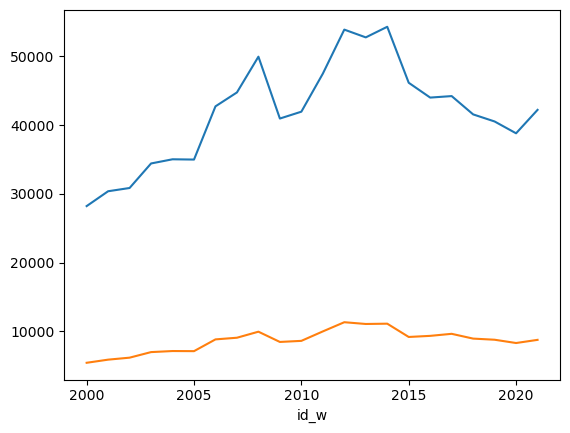

In [70]:
real_cons_s.plot()
constr_df[constr_df.id_w>1999].groupby('id_w').mean().CONSUMPTIONr.plot()

In [91]:
real_cons_s

id_w
2000    28205.277655
2001    30364.932190
2002    30838.213781
2003    34405.105882
2004    35013.725278
2005    34973.026920
2006    42712.123686
2007    44737.546176
2008    49936.500964
2009    40939.660370
2010    41937.057814
2011    47467.952050
2012    53872.888630
2013    52743.291257
2014    54284.884427
2015    46143.184512
2016    43987.269645
2017    44205.134048
2018    41542.537609
2019    40512.948064
2020    38792.702401
2021    42201.023739
dtype: float64

In [93]:
cpi_s.sort_index(ascending=False).cumprod()/cpi_s.sort_index(ascending=False).cumprod()[2021]

id_w
2021    1.000000
2020    1.049100
2019    1.080993
2018    1.127043
2017    1.155332
2016    1.217604
2015    1.374797
2014    1.530836
2013    1.629881
2012    1.736965
2011    1.842919
2010    2.004728
2009    2.181144
2008    2.470800
2007    2.764083
2006    3.012851
2005    3.341854
2004    3.733854
2003    4.181543
2002    4.811283
2001    5.705220
2000    6.856533
Name: CPI, dtype: float64

<AxesSubplot:xlabel='id_w'>

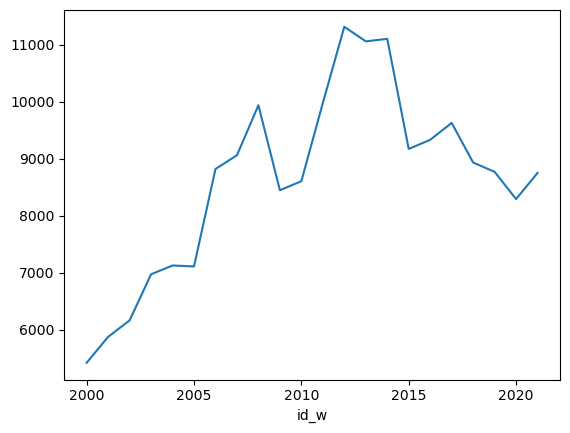

In [57]:
constr_df[constr_df.id_w>1999].groupby('id_w').mean().CONSUMPTIONr.plot()

In [97]:
cpi_aids.sort_index(ascending=True).cumprod()/(cpi_aids.sort_index(ascending=True).cumprod())[2000]

KeyError: 2000

In [98]:
(cpi_aids.sort_index(ascending=True).cumprod())[2000]

KeyError: 2000

In [73]:
np.log(real_cons_s)-stone_s

id_w
2000    9.046382
2001    8.886459
2002    8.671238
2003    8.563214
2004    8.337388
2005    8.080045
2006    8.026981
2007    7.748102
2008    7.408320
2009    6.879040
2010    6.581468
2011    6.401195
2012    6.140267
2013    5.778494
2014    5.168075
2015    4.209216
2016    3.780198
2017    3.599690
2018    3.244155
2019    2.960747
2020    2.622592
2021    1.991686
dtype: float64

In [289]:
np.log(cons_s.divide(cpi_s.cumprod(),axis=0))['CONSUMPTIONn']-(stone_s)


id_w
2000    6.92
2001    6.79
2002    6.59
2003    6.51
2004    6.30
2005    6.03
2006    6.02
2007    5.70
2008    5.35
2009    4.86
2010    4.63
2011    4.40
2012    4.14
2013    3.77
2014    3.10
2015    2.15
2016    1.78
2017    1.62
2018    1.26
2019    0.98
2020    0.63
2021   -0.04
dtype: float64

In [ ]:
def period_aids()

In [1]:
from linearmodels.datasets import munnell

data = munnell.load()

regions = {
    "GF": ["AL", "FL", "LA", "MS"],
    "MW": ["IL", "IN", "KY", "MI", "MN", "OH", "WI"],
    "MA": ["DE", "MD", "NJ", "NY", "PA", "VA"],
    "MT": ["CO", "ID", "MT", "ND", "SD", "WY"],
    "NE": ["CT", "ME", "MA", "NH", "RI", "VT"],
    "SO": ["GA", "NC", "SC", "TN", "WV", "AR"],
    "SW": ["AZ", "NV", "NM", "TX", "UT"],
    "CN": ["AK", "IA", "KS", "MO", "NE", "OK"],
    "WC": ["CA", "OR", "WA"],
}


def map_region(state):
    for key in regions:
        if state in regions[key]:
            return key


data["REGION"] = data.ST_ABB.map(map_region)
data["TOTAL_EMP"] = data.groupby(["REGION", "YR"])["EMP"].transform("sum")
data["EMP_SHARE"] = data.EMP / data.TOTAL_EMP
data["WEIGHED_UNEMP"] = data.EMP_SHARE * data.UNEMP

In [2]:
grouped = data.groupby(["REGION", "YR"])
agg_data = grouped[["GSP", "PC", "HWY", "WATER", "UTIL", "EMP", "WEIGHED_UNEMP"]].sum()
for col in ["GSP", "PC", "HWY", "WATER", "UTIL", "EMP"]:
    agg_data["ln" + col] = np.log(agg_data[col])
agg_data["UNEMP"] = agg_data.WEIGHED_UNEMP
agg_data["Intercept"] = 1.0

In [3]:
from collections import OrderedDict

mod_data = OrderedDict()
for region in ["GF", "SW", "WC", "MT", "NE", "MA", "SO", "MW", "CN"]:
    region_data = agg_data.loc[region]
    dependent = region_data.lnGSP
    exog = region_data[
        ["Intercept", "lnPC", "lnHWY", "lnWATER", "lnUTIL", "lnEMP", "UNEMP"]
    ]
    mod_data[region] = {"dependent": dependent, "exog": exog}

In [6]:
import pandas as pd
from linearmodels.system import SUR

mod = SUR(mod_data)
res = mod.fit(cov_type="unadjusted")

In [8]:
res

System GLS Estimation Summary                           
===================================================================================
Estimator:                        GLS   Overall R-squared:                   0.9937
No. Equations.:                     9   McElroy's R-squared:                 0.9988
No. Observations:                  17   Judge's (OLS) R-squared:             0.9937
Date:                Mon, Jun 12 2023   Berndt's R-squared:                  1.0000
Time:                        16:43:29   Dhrymes's R-squared:                 0.9937
                                        Cov. Estimator:                  unadjusted
                                        Num. Constraints:                      None
                   Equation: GF, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      12.310     2.2513     5.4680     0.0000      7.8976      16.723
lnPC          -0.2010     0.1424    -1.4117     0.1580     -0.4800      0.0780
lnHWY         -1.8856     0.5169    -3.6480     0.0003     -2.8987     -0.8725
lnWATER        0.1785     0.0607     2.9399     0.0033      0.0595      0.2975
lnUTIL         1.1898     0.3744     3.1774     0.0015      0.4559      1.9237
lnEMP          0.9533     0.0847     11.252     0.0000      0.7872      1.1193
UNEMP         -0.0031     0.0021    -1.5007     0.1334     -0.0072      0.0009
                   Equation: SW, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      4.0831     0.9979     4.0918     0.0000      2.1273      6.0389
lnPC           0.0766     0.0858     0.8929     0.3719     -0.0916      0.2449
lnHWY         -0.1312     0.1279    -1.0258     0.3050     -0.3819      0.1195
lnWATER       -0.1360     0.0611    -2.2240     0.0261     -0.2558     -0.0161
lnUTIL         0.5216     0.1107     4.7102     0.0000      0.3045      0.7386
lnEMP          0.5387     0.0849     6.3439     0.0000      0.3723      0.7051
UNEMP         -0.0156     0.0025    -6.2950     0.0000     -0.0205     -0.0108
                   Equation: WC, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.9602     3.4542     0.5675     0.5704     -4.8100      8.7303
lnPC           0.1699     0.0919     1.8500     0.0643     -0.0101      0.3500
lnHWY          0.1317     0.1138     1.1569     0.2473     -0.0914      0.3547
lnWATER       -0.3470     0.1733    -2.0020     0.0453     -0.6867     -0.0073
lnUTIL         0.0895     0.4642     0.1928     0.8471     -0.8204      0.9994
lnEMP          1.0696     0.1708     6.2634     0.0000      0.7349      1.4043
UNEMP         -0.0060     0.0042    -1.4180     0.1562     -0.0143      0.0023
                   Equation: MT, Dependent Variable: lnGSP                    
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.4633     1.4539     2.3821     0.0172      0.6138      6.3128
lnPC          -0.1148     0.0485    -2.3683     0.0179     -0.2099     -0.0198
lnHWY          0.1798     0.1794     1.0020     0.3164     -0.1719      0.5315
lnWATER        0.2615     0.0523     4.9988     0.0000      0.1590      0.3641
lnUTIL        -0.3296     0.1321

In [9]:
mod_data

OrderedDict([('GF',
              {'dependent': YR
               1970    12.089713
               1971    12.130395
               1972    12.203043
               1973    12.264492
               1974    12.259798
               1975    12.237659
               1976    12.279978
               1977    12.322740
               1978    12.388932
               1979    12.426781
               1980    12.447571
               1981    12.478422
               1982    12.468087
               1983    12.493775
               1984    12.558070
               1985    12.589888
               1986    12.602070
               Name: lnGSP, dtype: float64,
               'exog':       Intercept       lnPC      lnHWY   lnWATER     lnUTIL     lnEMP  \
               YR                                                                     
               1970        1.0  12.270658  10.456684  9.139493  10.318634  8.472217   
               1971        1.0  12.304015  10.482253  9.169568  10.356863  

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.stackplot(dfdf.index,dfdf.totfoodn,dfdf.totfueln,dfdf.totclothn, 
             dfdf.totdurabn, dfdf.totluxurn, dfdf.totservicen, dfdf.totothern,
             dfdf.tothealthn,
             alpha=1)


ax.set_title('')
ax.set_xlabel('Год',fontweight='bold')
ax.set_ylabel('Средняя доля агрегата \nв расходах',fontweight='bold')
ax.legend(dfdf.columns,loc='best', bbox_to_anchor=(0.85, 0.5, 0.5, 0.5))
plt.xticks(rotation=70)
ax.set_xticks(range(1994,2022),rotation=135)
plt.xlim(1994,2021)
plt.ylim(0,1)
plt.grid()
plt.show()